# Bitcoin Trader Performance vs Market Sentiment Analysis

## Assignment Overview
This notebook analyzes the relationship between trader performance on Hyperliquid and Bitcoin market sentiment (Fear & Greed Index).

**Objectives:**
1. Explore how trader performance varies with market sentiment
2. Detect correlations between sentiment and profitability
3. Identify behavioral patterns during Fear vs Greed periods
4. Provide actionable trading insights

## 1. Import Libraries and Setup

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("✓ Libraries imported successfully")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Matplotlib version: {plt.matplotlib.__version__}")
print(f"✓ Seaborn version: {sns.__version__}")

✓ Libraries imported successfully
✓ Pandas version: 2.3.3
✓ NumPy version: 2.3.4
✓ Matplotlib version: 3.10.7
✓ Seaborn version: 0.13.2


## 2. Load and Explore Datasets

In [2]:
# Load datasets
fear_greed_df = pd.read_csv('fear_greed_index.csv')
historical_df = pd.read_csv('historical_data.csv')

print("Fear & Greed Index Dataset:")
print(f"Shape: {fear_greed_df.shape}")
print(f"\nFirst few rows:")
display(fear_greed_df.head())

print("\n" + "="*80)
print("\nHistorical Trading Data:")
print(f"Shape: {historical_df.shape}")
print(f"\nFirst few rows:")
display(historical_df.head())

Fear & Greed Index Dataset:
Shape: (2644, 4)

First few rows:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05




Historical Trading Data:
Shape: (211224, 16)

First few rows:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,"7,872.16",BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,"895,000,000,000,000.00","1,730,000,000,000.00"
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,"443,000,000,000,000.00","1,730,000,000,000.00"
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,"1,150.63",BUY,02-12-2024 22:50,"1,002.52",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,"660,000,000,000,000.00","1,730,000,000,000.00"
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,"1,142.04",BUY,02-12-2024 22:50,"1,146.56",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,"1,080,000,000,000,000.00","1,730,000,000,000.00"
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,"1,289.49",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,"1,050,000,000,000,000.00","1,730,000,000,000.00"


In [3]:
# Comprehensive data exploration
print("="*80)
print(" "*25 + "DATA QUALITY ASSESSMENT")
print("="*80)

print("\n📊 Fear & Greed Index - Column Information:")
print("-" * 60)
for col in fear_greed_df.columns:
    dtype = fear_greed_df[col].dtype
    unique = fear_greed_df[col].nunique()
    null_count = fear_greed_df[col].isnull().sum()
    null_pct = (null_count / len(fear_greed_df)) * 100
    print(f"  {col:20s} | Type: {str(dtype):10s} | Unique: {unique:6,} | Nulls: {null_count:4} ({null_pct:.1f}%)")

print(f"\n  Total Missing Values: {fear_greed_df.isnull().sum().sum()}")
print(f"  Duplicate Rows: {fear_greed_df.duplicated().sum()}")

print("\n" + "="*80)
print("\n📈 Historical Trading Data - Column Information:")
print("-" * 60)
for col in historical_df.columns:
    dtype = historical_df[col].dtype
    unique = historical_df[col].nunique()
    null_count = historical_df[col].isnull().sum()
    null_pct = (null_count / len(historical_df)) * 100
    print(f"  {col:20s} | Type: {str(dtype):10s} | Unique: {unique:6,} | Nulls: {null_count:4} ({null_pct:.1f}%)")

print(f"\n  Total Missing Values: {historical_df.isnull().sum().sum()}")
print(f"  Duplicate Rows: {historical_df.duplicated().sum()}")

# Statistical summary for numeric columns
print("\n" + "="*80)
print("\n📊 Historical Data - Numeric Summary:")
print("-" * 60)
display(historical_df.describe())

                         DATA QUALITY ASSESSMENT

📊 Fear & Greed Index - Column Information:
------------------------------------------------------------
  timestamp            | Type: int64      | Unique:  2,644 | Nulls:    0 (0.0%)
  value                | Type: int64      | Unique:     90 | Nulls:    0 (0.0%)
  classification       | Type: object     | Unique:      5 | Nulls:    0 (0.0%)
  date                 | Type: object     | Unique:  2,644 | Nulls:    0 (0.0%)

  Total Missing Values: 0
  Duplicate Rows: 0


📈 Historical Trading Data - Column Information:
------------------------------------------------------------
  Account              | Type: object     | Unique:     32 | Nulls:    0 (0.0%)
  Coin                 | Type: object     | Unique:    246 | Nulls:    0 (0.0%)
  Execution Price      | Type: float64    | Unique: 60,162 | Nulls:    0 (0.0%)
  Size Tokens          | Type: float64    | Unique: 59,304 | Nulls:    0 (0.0%)
  Size USD             | Type: float64    | Uniq

,Execution Price,Size Tokens,Size USD,Start Position,Closed PnL,Order ID,Fee,Trade ID,Timestamp
count,"211,224.00","211,224.00","211,224.00","211,224.00","211,224.00","211,224.00","211,224.00","211,224.00","211,224.00"
mean,"11,414.72","4,623.36","5,639.45","-29,946.25",48.75,"69,653,876,008.97",1.16,"562,854,854,500,788.56","1,737,744,290,421.54"
std,"29,447.65","104,272.89","36,575.14","673,807.42",919.16,"18,357,525,271.93",6.76,"325,756,470,346,550.31","8,689,920,301.57"
min,0.00,0.00,0.00,"-14,334,629.00","-117,990.10","173,271,100.00",-1.18,0.00,"1,680,000,000,000.00"
25%,4.85,2.94,193.79,-376.23,0.00,"59,838,527,992.75",0.02,"281,000,000,000,000.00","1,740,000,000,000.00"
50%,18.28,32.00,597.05,84.73,0.00,"74,429,390,066.00",0.09,"562,000,000,000,000.00","1,740,000,000,000.00"
75%,101.58,187.90,"2,058.96","9,337.28",5.79,"83,355,430,544.00",0.39,"846,000,000,000,000.00","1,740,000,000,000.00"
max,"109,004.00","15,822,438.00","3,921,430.72","30,509,482.00","135,329.09","90,149,230,487.00",837.47,"1,130,000,000,000,000.00","1,750,000,000,000.00"


## 3. Data Cleaning and Preprocessing

In [4]:
# Clean Fear & Greed Index data
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df = fear_greed_df.sort_values('date').reset_index(drop=True)

print("Fear & Greed Index - Date Range:")
print(f"From: {fear_greed_df['date'].min()}")
print(f"To: {fear_greed_df['date'].max()}")
print(f"\nSentiment Distribution:")
print(fear_greed_df['classification'].value_counts())

Fear & Greed Index - Date Range:
From: 2018-02-01 00:00:00
To: 2025-05-02 00:00:00

Sentiment Distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [5]:
# Clean Historical Trading Data
# Parse the timestamp column - assuming it's in IST format
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
historical_df['Date'] = historical_df['Timestamp IST'].dt.date
historical_df['Date'] = pd.to_datetime(historical_df['Date'])

# Clean numeric columns
historical_df['Closed PnL'] = pd.to_numeric(historical_df['Closed PnL'], errors='coerce')
historical_df['Size USD'] = pd.to_numeric(historical_df['Size USD'], errors='coerce')
historical_df['Fee'] = pd.to_numeric(historical_df['Fee'], errors='coerce')

# Remove rows with invalid dates
historical_df = historical_df.dropna(subset=['Date'])

print("Historical Trading Data - Date Range:")
print(f"From: {historical_df['Date'].min()}")
print(f"To: {historical_df['Date'].max()}")
print(f"\nTotal Trades: {len(historical_df):,}")
print(f"\nTrade Side Distribution:")
print(historical_df['Side'].value_counts())

Historical Trading Data - Date Range:
From: 2023-05-01 00:00:00
To: 2025-05-01 00:00:00

Total Trades: 211,224

Trade Side Distribution:
Side
SELL    108528
BUY     102696
Name: count, dtype: int64


## 4. Merge Datasets Based on Date

In [6]:
# Merge datasets on date
merged_df = pd.merge(
    historical_df,
    fear_greed_df[['date', 'value', 'classification']],
    left_on='Date',
    right_on='date',
    how='left'
)

# For dates without sentiment data, use forward fill
merged_df['classification'] = merged_df.groupby(merged_df['Date'].notna())['classification'].fillna(method='ffill')
merged_df['value'] = merged_df.groupby(merged_df['Date'].notna())['value'].fillna(method='ffill')

# Drop rows where we still don't have sentiment data
merged_df = merged_df.dropna(subset=['classification'])

print(f"Merged Dataset Shape: {merged_df.shape}")
print(f"\nSentiment Coverage: {merged_df['classification'].notna().sum() / len(merged_df) * 100:.2f}%")
print(f"\nSample of merged data:")
display(merged_df[['Date', 'Side', 'Closed PnL', 'Size USD', 'classification', 'value']].head(10))

Merged Dataset Shape: (211224, 20)

Sentiment Coverage: 100.00%

Sample of merged data:


,Date,Side,Closed PnL,Size USD,classification,value
0,2024-12-02,BUY,0.00,"7,872.16",Extreme Greed,80.00
1,2024-12-02,BUY,0.00,127.68,Extreme Greed,80.00
2,2024-12-02,BUY,0.00,"1,150.63",Extreme Greed,80.00
3,2024-12-02,BUY,0.00,"1,142.04",Extreme Greed,80.00
4,2024-12-02,BUY,0.00,69.75,Extreme Greed,80.00
5,2024-12-02,BUY,0.00,11.27,Extreme Greed,80.00
6,2024-12-02,BUY,0.00,"1,151.77",Extreme Greed,80.00
7,2024-12-02,BUY,0.00,272.00,Extreme Greed,80.00
8,2024-12-02,BUY,0.00,368.00,Extreme Greed,80.00
9,2024-12-02,BUY,0.00,100.00,Extreme Greed,80.00


## 5. Feature Engineering

In [7]:
# Enhanced feature engineering
print("="*80)
print(" "*25 + "FEATURE ENGINEERING")
print("="*80)

# Basic features
merged_df['Net_PnL'] = merged_df['Closed PnL'] - merged_df['Fee']
merged_df['is_profitable'] = merged_df['Net_PnL'] > 0
merged_df['Hour'] = merged_df['Timestamp IST'].dt.hour
merged_df['DayOfWeek'] = merged_df['Timestamp IST'].dt.dayofweek
merged_df['Month'] = merged_df['Timestamp IST'].dt.month
merged_df['Week'] = merged_df['Timestamp IST'].dt.isocalendar().week

# Categorize sentiment into broader groups
def categorize_sentiment(classification):
    sentiment_map = {
        'Extreme Fear': 'Extreme Fear',
        'Fear': 'Fear',
        'Neutral': 'Neutral',
        'Greed': 'Greed',
        'Extreme Greed': 'Extreme Greed'
    }
    return sentiment_map.get(classification, 'Neutral')

merged_df['sentiment_category'] = merged_df['classification'].apply(categorize_sentiment)

# Advanced features
# 1. PnL as percentage of trade size
merged_df['PnL_Percentage'] = (merged_df['Net_PnL'] / merged_df['Size USD']) * 100

# 2. Fee ratio
merged_df['Fee_Ratio'] = (merged_df['Fee'] / merged_df['Size USD']) * 100

# 3. Sentiment score (numeric)
sentiment_score_map = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}
merged_df['sentiment_score'] = merged_df['sentiment_category'].map(sentiment_score_map)

# 4. Trading session (Asian/European/American)
def get_trading_session(hour):
    if 0 <= hour < 8:
        return 'Asian'
    elif 8 <= hour < 16:
        return 'European'
    else:
        return 'American'

merged_df['Trading_Session'] = merged_df['Hour'].apply(get_trading_session)

# 5. Win/Loss magnitude
merged_df['Win_Loss_Magnitude'] = merged_df['Net_PnL'].abs()

# 6. Consecutive trade analysis (simplified)
merged_df['Trade_Number'] = range(1, len(merged_df) + 1)

print(f"\n✓ Created {len(merged_df.columns) - len(historical_df.columns)} new features")
print(f"\nNew Feature Summary:")
print(f"  - Net_PnL: Net profit/loss after fees")
print(f"  - is_profitable: Boolean indicator of profitability")
print(f"  - Hour, DayOfWeek, Month, Week: Time-based features")
print(f"  - sentiment_category: Categorized market sentiment")
print(f"  - PnL_Percentage: PnL as % of trade size")
print(f"  - Fee_Ratio: Fee as % of trade size")
print(f"  - sentiment_score: Numeric sentiment (1-5)")
print(f"  - Trading_Session: Asian/European/American session")
print(f"  - Win_Loss_Magnitude: Absolute value of PnL")

print(f"\n📊 Enhanced Dataset Sample:")
display(merged_df[['Date', 'Side', 'Net_PnL', 'PnL_Percentage', 'sentiment_category', 
                   'sentiment_score', 'Trading_Session']].head(10))

                         FEATURE ENGINEERING

✓ Created 16 new features

New Feature Summary:
  - Net_PnL: Net profit/loss after fees
  - is_profitable: Boolean indicator of profitability
  - Hour, DayOfWeek, Month, Week: Time-based features
  - sentiment_category: Categorized market sentiment
  - PnL_Percentage: PnL as % of trade size
  - Fee_Ratio: Fee as % of trade size
  - sentiment_score: Numeric sentiment (1-5)
  - Trading_Session: Asian/European/American session
  - Win_Loss_Magnitude: Absolute value of PnL

📊 Enhanced Dataset Sample:

✓ Created 16 new features

New Feature Summary:
  - Net_PnL: Net profit/loss after fees
  - is_profitable: Boolean indicator of profitability
  - Hour, DayOfWeek, Month, Week: Time-based features
  - sentiment_category: Categorized market sentiment
  - PnL_Percentage: PnL as % of trade size
  - Fee_Ratio: Fee as % of trade size
  - sentiment_score: Numeric sentiment (1-5)
  - Trading_Session: Asian/European/American session
  - Win_Loss_Magnitude:

,Date,Side,Net_PnL,PnL_Percentage,sentiment_category,sentiment_score,Trading_Session
0,2024-12-02,BUY,-0.35,-0.00,Extreme Greed,5,American
1,2024-12-02,BUY,-0.01,-0.00,Extreme Greed,5,American
2,2024-12-02,BUY,-0.05,-0.00,Extreme Greed,5,American
3,2024-12-02,BUY,-0.05,-0.00,Extreme Greed,5,American
4,2024-12-02,BUY,-0.00,-0.00,Extreme Greed,5,American
5,2024-12-02,BUY,-0.00,-0.00,Extreme Greed,5,American
6,2024-12-02,BUY,-0.05,-0.00,Extreme Greed,5,American
7,2024-12-02,BUY,-0.01,-0.00,Extreme Greed,5,American
8,2024-12-02,BUY,-0.02,-0.00,Extreme Greed,5,American
9,2024-12-02,BUY,-0.00,-0.00,Extreme Greed,5,American


## 6. Exploratory Data Analysis (EDA)

### 6.1 Overall Performance Metrics

In [8]:
# Calculate overall metrics
total_trades = len(merged_df)
total_pnl = merged_df['Net_PnL'].sum()
total_fees = merged_df['Fee'].sum()
win_rate = (merged_df['is_profitable'].sum() / total_trades) * 100
avg_pnl_per_trade = merged_df['Net_PnL'].mean()
total_volume = merged_df['Size USD'].sum()

print("="*80)
print(" "*25 + "OVERALL PERFORMANCE METRICS")
print("="*80)
print(f"Total Trades: {total_trades:,}")
print(f"Total Net PnL: ${total_pnl:,.2f}")
print(f"Total Fees Paid: ${total_fees:,.2f}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average PnL per Trade: ${avg_pnl_per_trade:.2f}")
print(f"Total Trading Volume: ${total_volume:,.2f}")
print("="*80)

                         OVERALL PERFORMANCE METRICS
Total Trades: 211,224
Total Net PnL: $10,051,101.22
Total Fees Paid: $245,857.72
Win Rate: 41.02%
Average PnL per Trade: $47.59
Total Trading Volume: $1,191,187,442.46


### 6.2 Performance by Sentiment

In [9]:
# Group by sentiment category
sentiment_performance = merged_df.groupby('sentiment_category').agg({
    'Net_PnL': ['sum', 'mean', 'std'],
    'Size USD': ['sum', 'mean'],
    'Fee': 'sum',
    'is_profitable': 'mean',
    'Account': 'count'
}).round(2)

sentiment_performance.columns = ['Total_PnL', 'Avg_PnL', 'Std_PnL', 'Total_Volume', 'Avg_Trade_Size', 'Total_Fees', 'Win_Rate', 'Trade_Count']
sentiment_performance['Win_Rate'] = sentiment_performance['Win_Rate'] * 100
sentiment_performance = sentiment_performance.sort_values('Total_PnL', ascending=False)

print("Performance Metrics by Market Sentiment:")
print("="*120)
display(sentiment_performance)

Performance Metrics by Market Sentiment:


,Total_PnL,Avg_PnL,Std_PnL,Total_Volume,Avg_Trade_Size,Total_Fees,Win_Rate,Trade_Count
sentiment_category,,,,,,,,
Fear,"3,264,698.49",52.80,934.64,"483,324,789.79","7,816.11","92,456.95",41.00,61837
Extreme Greed,"2,688,140.65",67.22,766.53,"124,465,164.57","3,112.25","27,030.67",47.00,39992
Greed,"2,129,494.06",42.33,"1,120.18","288,671,163.58","5,737.96","63,107.20",39.00,50309
Neutral,"1,253,546.41",33.26,515.68,"180,242,063.08","4,782.73","39,374.27",40.00,37686
Extreme Fear,"715,221.61",33.42,"1,134.68","114,484,261.44","5,349.73","23,888.63",37.00,21400


### 6.3 Trade Side Distribution by Sentiment

In [10]:
# Analyze buy/sell patterns by sentiment
side_sentiment = pd.crosstab(merged_df['sentiment_category'], merged_df['Side'], normalize='index') * 100
print("Trade Side Distribution by Sentiment (%)")
print("="*60)
display(side_sentiment.round(2))

Trade Side Distribution by Sentiment (%)


Side,BUY,SELL
sentiment_category,,
Extreme Fear,51.10,48.90
Extreme Greed,44.86,55.14
Fear,48.95,51.05
Greed,48.86,51.14
Neutral,50.33,49.67


## 7. Data Visualizations

### 7.1 Average PnL by Sentiment

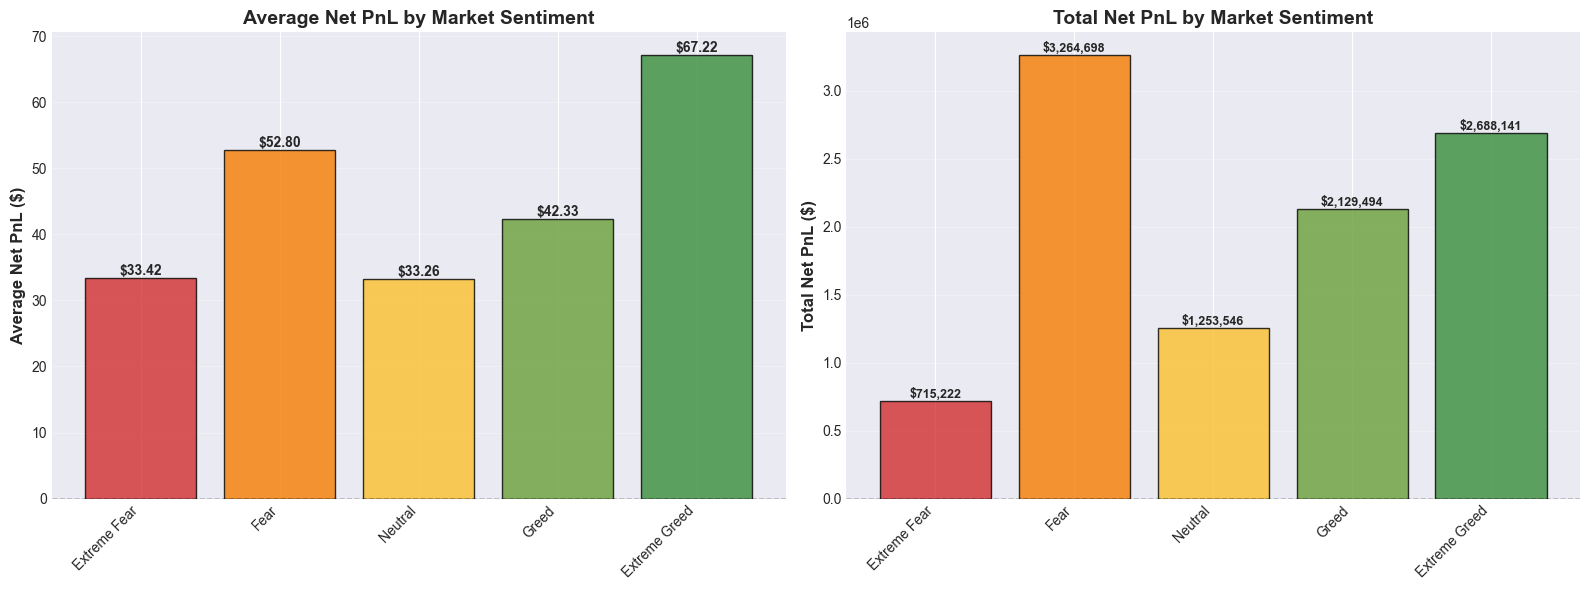

In [11]:
# Bar chart: Average PnL by sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Average PnL
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
avg_pnl_by_sentiment = merged_df.groupby('sentiment_category')['Net_PnL'].mean().reindex(sentiment_order)

colors = ['#d32f2f', '#f57c00', '#fbc02d', '#689f38', '#388e3c']
bars = ax1.bar(range(len(avg_pnl_by_sentiment)), avg_pnl_by_sentiment.values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_xticks(range(len(sentiment_order)))
ax1.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax1.set_ylabel('Average Net PnL ($)', fontsize=12, fontweight='bold')
ax1.set_title('Average Net PnL by Market Sentiment', fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}',
             ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# Total PnL
total_pnl_by_sentiment = merged_df.groupby('sentiment_category')['Net_PnL'].sum().reindex(sentiment_order)
bars2 = ax2.bar(range(len(total_pnl_by_sentiment)), total_pnl_by_sentiment.values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(sentiment_order)))
ax2.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax2.set_ylabel('Total Net PnL ($)', fontsize=12, fontweight='bold')
ax2.set_title('Total Net PnL by Market Sentiment', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 7.2 Win Rate by Sentiment

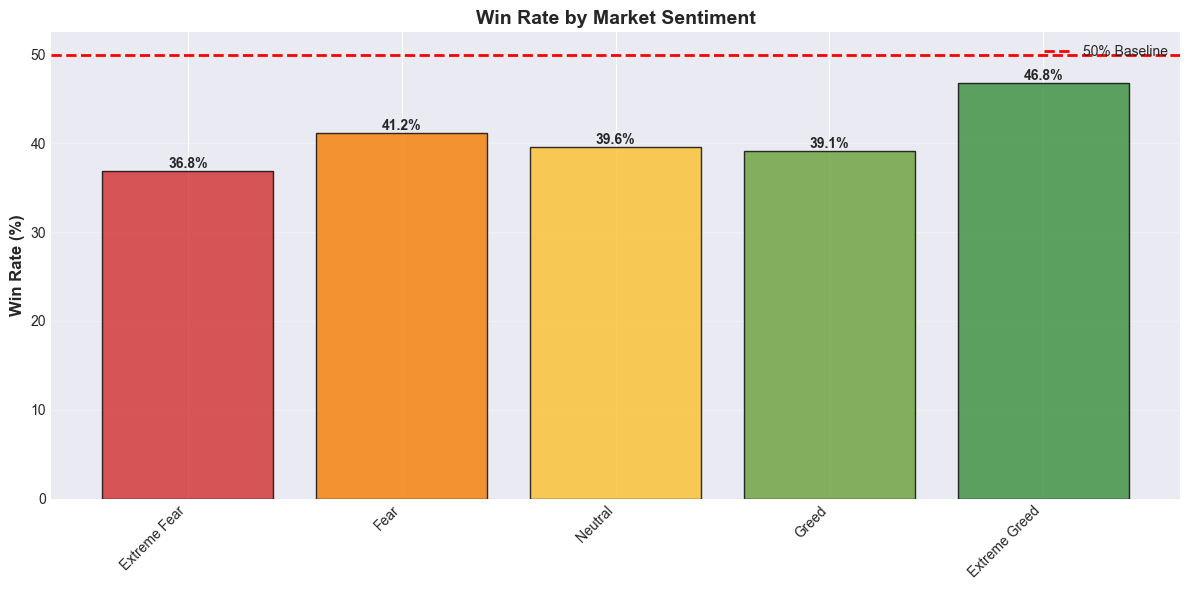

In [12]:
# Win rate by sentiment
fig, ax = plt.subplots(figsize=(12, 6))

win_rate_by_sentiment = (merged_df.groupby('sentiment_category')['is_profitable'].mean() * 100).reindex(sentiment_order)

bars = ax.bar(range(len(win_rate_by_sentiment)), win_rate_by_sentiment.values, color=colors, edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(sentiment_order)))
ax.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Win Rate by Market Sentiment', fontsize=14, fontweight='bold')
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% Baseline')
ax.grid(axis='y', alpha=0.3)
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 7.3 Trade Volume by Sentiment

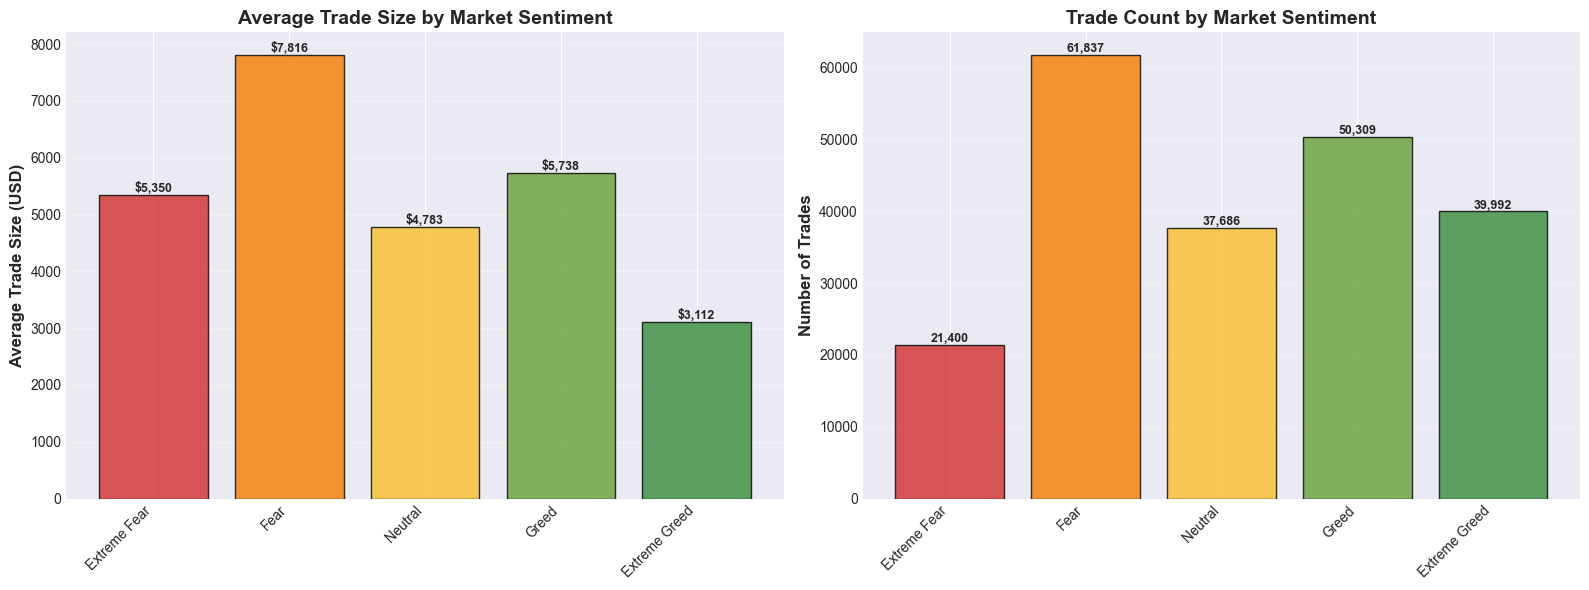

In [13]:
# Trade volume and count by sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Average trade size
avg_size_by_sentiment = merged_df.groupby('sentiment_category')['Size USD'].mean().reindex(sentiment_order)
bars1 = ax1.bar(range(len(avg_size_by_sentiment)), avg_size_by_sentiment.values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_xticks(range(len(sentiment_order)))
ax1.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax1.set_ylabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Average Trade Size by Market Sentiment', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Trade count
trade_count_by_sentiment = merged_df.groupby('sentiment_category').size().reindex(sentiment_order)
bars2 = ax2.bar(range(len(trade_count_by_sentiment)), trade_count_by_sentiment.values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(sentiment_order)))
ax2.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax2.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
ax2.set_title('Trade Count by Market Sentiment', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 7.4 Buy vs Sell Distribution by Sentiment

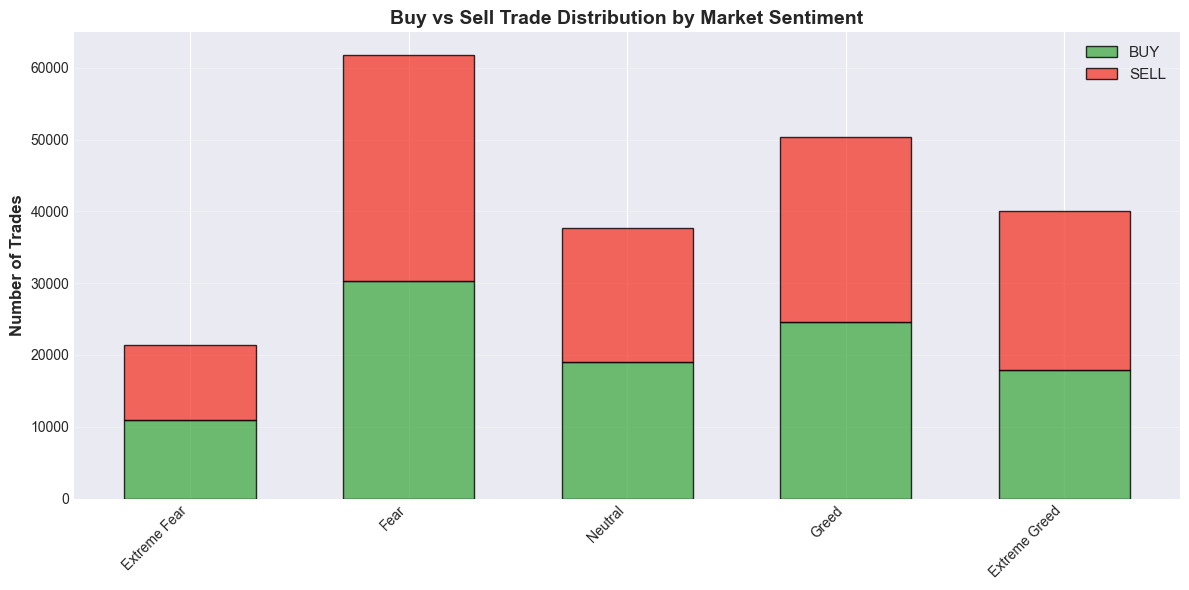

In [14]:
# Stacked bar chart: Buy vs Sell by sentiment
fig, ax = plt.subplots(figsize=(12, 6))

side_counts = pd.crosstab(merged_df['sentiment_category'], merged_df['Side'])
side_counts = side_counts.reindex(sentiment_order)

x = np.arange(len(sentiment_order))
width = 0.6

if 'BUY' in side_counts.columns and 'SELL' in side_counts.columns:
    p1 = ax.bar(x, side_counts['BUY'], width, label='BUY', color='#4caf50', alpha=0.8, edgecolor='black')
    p2 = ax.bar(x, side_counts['SELL'], width, bottom=side_counts['BUY'], label='SELL', color='#f44336', alpha=0.8, edgecolor='black')
elif 'BUY' in side_counts.columns:
    p1 = ax.bar(x, side_counts['BUY'], width, label='BUY', color='#4caf50', alpha=0.8, edgecolor='black')
else:
    p2 = ax.bar(x, side_counts['SELL'], width, label='SELL', color='#f44336', alpha=0.8, edgecolor='black')

ax.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
ax.set_title('Buy vs Sell Trade Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.5 Time Series: Cumulative PnL and Sentiment

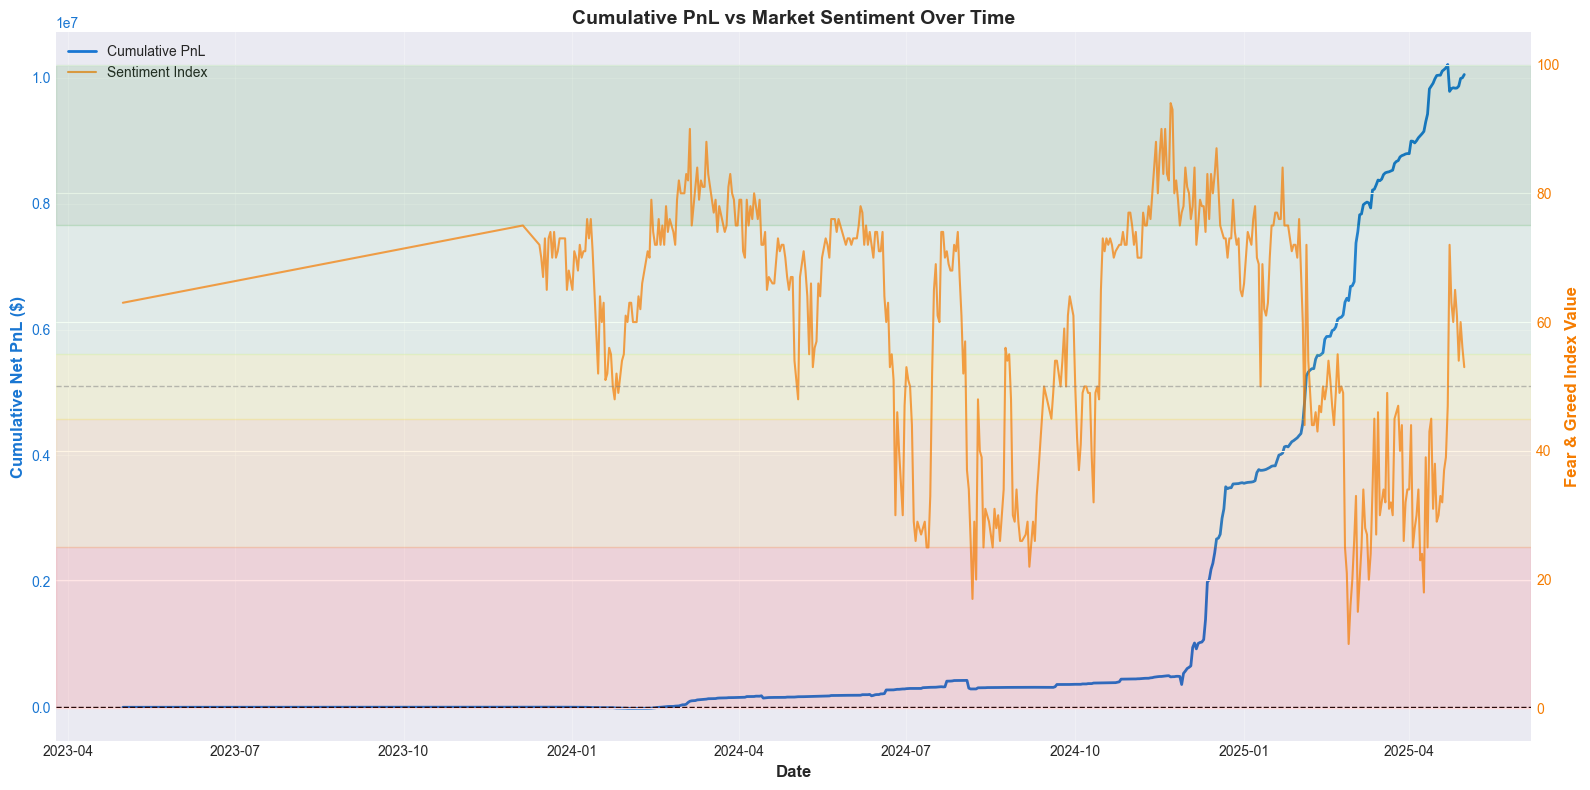

In [15]:
# Time series analysis
daily_performance = merged_df.groupby('Date').agg({
    'Net_PnL': 'sum',
    'value': 'first',
    'classification': 'first'
}).reset_index()

daily_performance['Cumulative_PnL'] = daily_performance['Net_PnL'].cumsum()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot cumulative PnL
color = '#1976d2'
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Net PnL ($)', color=color, fontsize=12, fontweight='bold')
line1 = ax1.plot(daily_performance['Date'], daily_performance['Cumulative_PnL'], 
                 color=color, linewidth=2, label='Cumulative PnL')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Create second y-axis for sentiment
ax2 = ax1.twinx()
color = '#f57c00'
ax2.set_ylabel('Fear & Greed Index Value', color=color, fontsize=12, fontweight='bold')
line2 = ax2.plot(daily_performance['Date'], daily_performance['value'], 
                 color=color, linewidth=1.5, alpha=0.7, label='Sentiment Index')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add sentiment zones
ax2.axhspan(0, 25, alpha=0.1, color='red', label='Extreme Fear')
ax2.axhspan(25, 45, alpha=0.1, color='orange', label='Fear')
ax2.axhspan(45, 55, alpha=0.1, color='yellow', label='Neutral')
ax2.axhspan(55, 75, alpha=0.1, color='lightgreen', label='Greed')
ax2.axhspan(75, 100, alpha=0.1, color='green', label='Extreme Greed')

plt.title('Cumulative PnL vs Market Sentiment Over Time', fontsize=14, fontweight='bold')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

### 7.6 Distribution of PnL by Sentiment

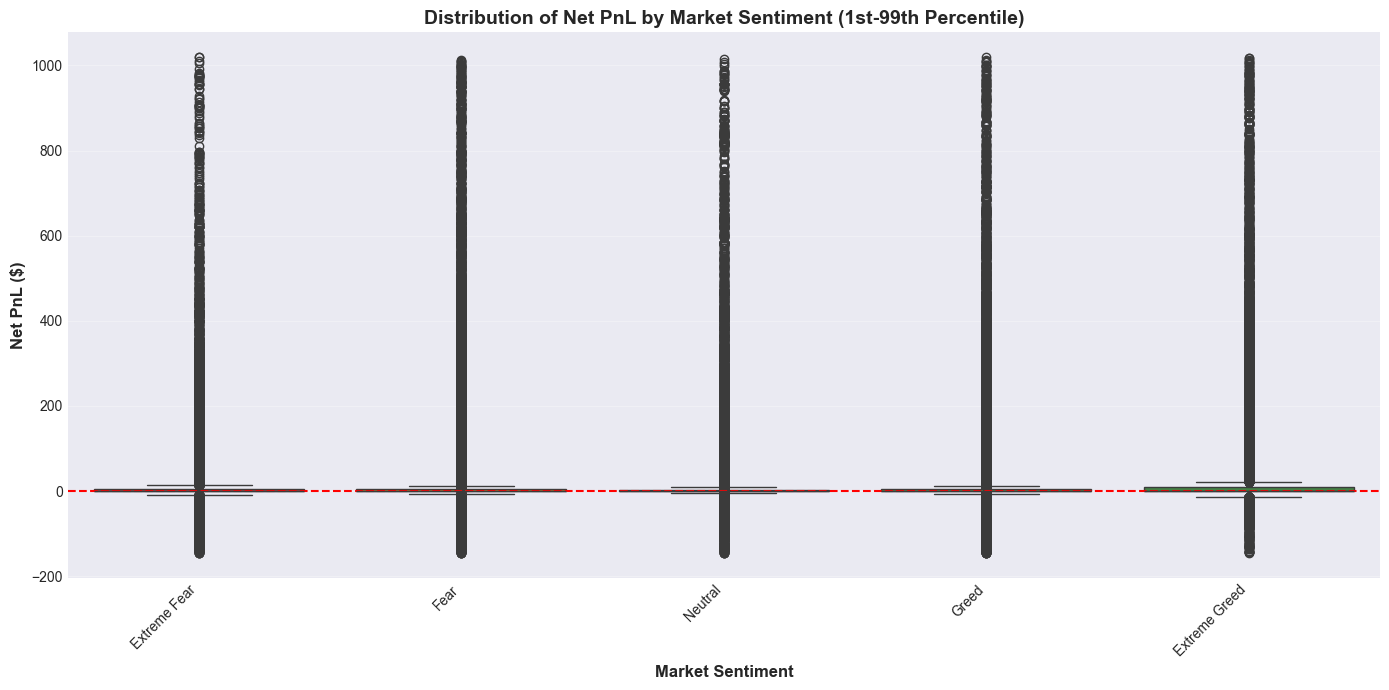

In [16]:
# Box plot: PnL distribution by sentiment
fig, ax = plt.subplots(figsize=(14, 7))

# Filter extreme outliers for better visualization
pnl_data = merged_df[merged_df['Net_PnL'].between(merged_df['Net_PnL'].quantile(0.01), 
                                                    merged_df['Net_PnL'].quantile(0.99))]

sns.boxplot(data=pnl_data, x='sentiment_category', y='Net_PnL', 
            order=sentiment_order, palette=colors, ax=ax)
ax.set_xlabel('Market Sentiment', fontsize=12, fontweight='bold')
ax.set_ylabel('Net PnL ($)', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Net PnL by Market Sentiment (1st-99th Percentile)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 7.7 Correlation Heatmap

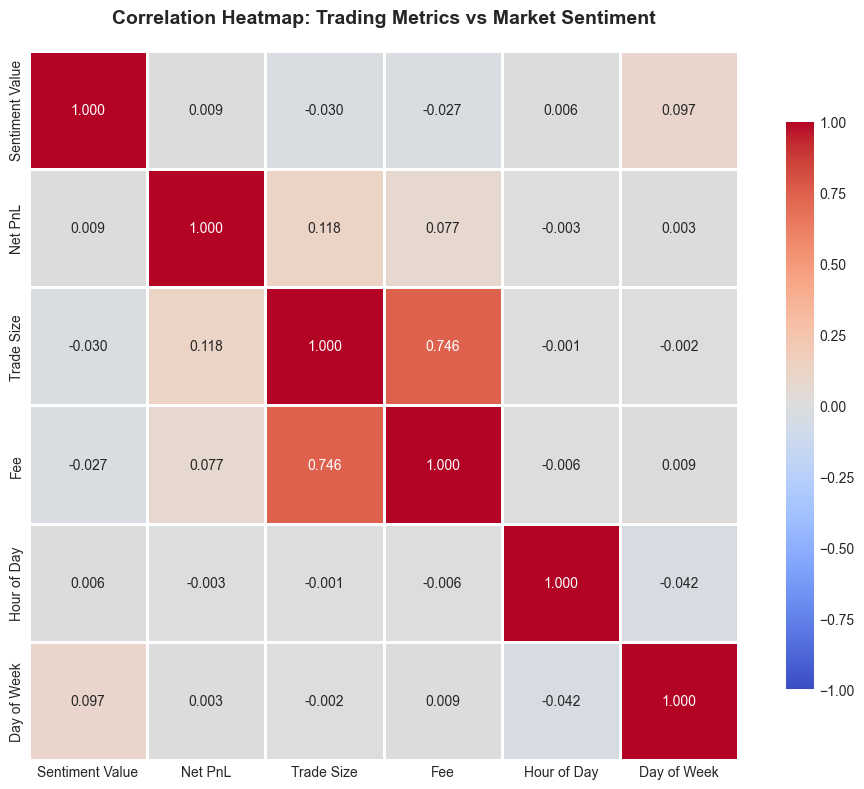


Key Correlations with Sentiment Value:
Day of Week: 0.0973
Net PnL: 0.0085
Hour of Day: 0.0056
Fee: -0.0269
Trade Size: -0.0298


In [17]:
# Create correlation matrix for numeric features
numeric_features = merged_df[['value', 'Net_PnL', 'Size USD', 'Fee', 'Hour', 'DayOfWeek']].copy()
numeric_features.columns = ['Sentiment Value', 'Net PnL', 'Trade Size', 'Fee', 'Hour of Day', 'Day of Week']

correlation_matrix = numeric_features.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Heatmap: Trading Metrics vs Market Sentiment', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Sentiment Value:")
print("="*60)
sentiment_corr = correlation_matrix['Sentiment Value'].sort_values(ascending=False)
for feature, corr in sentiment_corr.items():
    if feature != 'Sentiment Value':
        print(f"{feature}: {corr:.4f}")

### 7.9 Advanced Statistical Analysis - Statistical Significance Testing

In [18]:
# Statistical significance testing between sentiments
from scipy.stats import f_oneway, kruskal, mannwhitneyu, chi2_contingency

print("="*80)
print(" "*20 + "STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

# Prepare data for each sentiment category
sentiment_groups = {}
for sentiment in sentiment_order:
    sentiment_groups[sentiment] = merged_df[merged_df['sentiment_category'] == sentiment]['Net_PnL'].dropna()

# 1. ANOVA Test - Check if means across sentiments are significantly different
print("\n1. One-Way ANOVA Test (PnL across Sentiments)")
print("-" * 60)
f_stat, p_value = f_oneway(*[sentiment_groups[s] for s in sentiment_order if s in sentiment_groups])
print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"   ✓ Result: SIGNIFICANT - PnL differs significantly across sentiments (p < 0.05)")
else:
    print(f"   ✗ Result: NOT SIGNIFICANT - No significant difference detected (p >= 0.05)")

# 2. Kruskal-Wallis Test (non-parametric alternative)
print("\n2. Kruskal-Wallis Test (Non-parametric)")
print("-" * 60)
h_stat, p_value_kw = kruskal(*[sentiment_groups[s] for s in sentiment_order if s in sentiment_groups])
print(f"   H-statistic: {h_stat:.4f}")
print(f"   P-value: {p_value_kw:.6f}")
if p_value_kw < 0.05:
    print(f"   ✓ Result: SIGNIFICANT - Distribution differs across sentiments")
else:
    print(f"   ✗ Result: NOT SIGNIFICANT")

# 3. Chi-square test for profitability across sentiments
print("\n3. Chi-Square Test (Profitability vs Sentiment)")
print("-" * 60)
contingency_table = pd.crosstab(merged_df['sentiment_category'], merged_df['is_profitable'])
chi2, p_value_chi, dof, expected = chi2_contingency(contingency_table)
print(f"   Chi-square statistic: {chi2:.4f}")
print(f"   P-value: {p_value_chi:.6f}")
print(f"   Degrees of freedom: {dof}")
if p_value_chi < 0.05:
    print(f"   ✓ Result: SIGNIFICANT - Profitability depends on sentiment")
else:
    print(f"   ✗ Result: NOT SIGNIFICANT")

# 4. Pairwise comparisons (Fear vs Greed)
print("\n4. Pairwise Comparison: Extreme Fear vs Extreme Greed")
print("-" * 60)
if 'Extreme Fear' in sentiment_groups and 'Extreme Greed' in sentiment_groups:
    stat, p_value_mw = mannwhitneyu(sentiment_groups['Extreme Fear'], 
                                     sentiment_groups['Extreme Greed'], 
                                     alternative='two-sided')
    print(f"   Mann-Whitney U statistic: {stat:.4f}")
    print(f"   P-value: {p_value_mw:.6f}")
    if p_value_mw < 0.05:
        print(f"   ✓ Result: SIGNIFICANT difference between Extreme Fear and Extreme Greed")
    else:
        print(f"   ✗ Result: NO SIGNIFICANT difference")

print("\n" + "="*80)

                    STATISTICAL SIGNIFICANCE TESTING

1. One-Way ANOVA Test (PnL across Sentiments)
------------------------------------------------------------
   F-statistic: 9.0388
   P-value: 0.000000
   ✓ Result: SIGNIFICANT - PnL differs significantly across sentiments (p < 0.05)

2. Kruskal-Wallis Test (Non-parametric)
------------------------------------------------------------
   H-statistic: 1175.2482
   P-value: 0.000000
   ✓ Result: SIGNIFICANT - Distribution differs across sentiments

3. Chi-Square Test (Profitability vs Sentiment)
------------------------------------------------------------
   Chi-square statistic: 806.9168
   P-value: 0.000000
   Degrees of freedom: 4
   ✓ Result: SIGNIFICANT - Profitability depends on sentiment

4. Pairwise Comparison: Extreme Fear vs Extreme Greed
------------------------------------------------------------
   Mann-Whitney U statistic: 379305618.5000
   P-value: 0.000000
   ✓ Result: SIGNIFICANT difference between Extreme Fear and Extr

### 7.10 Volatility Analysis by Sentiment

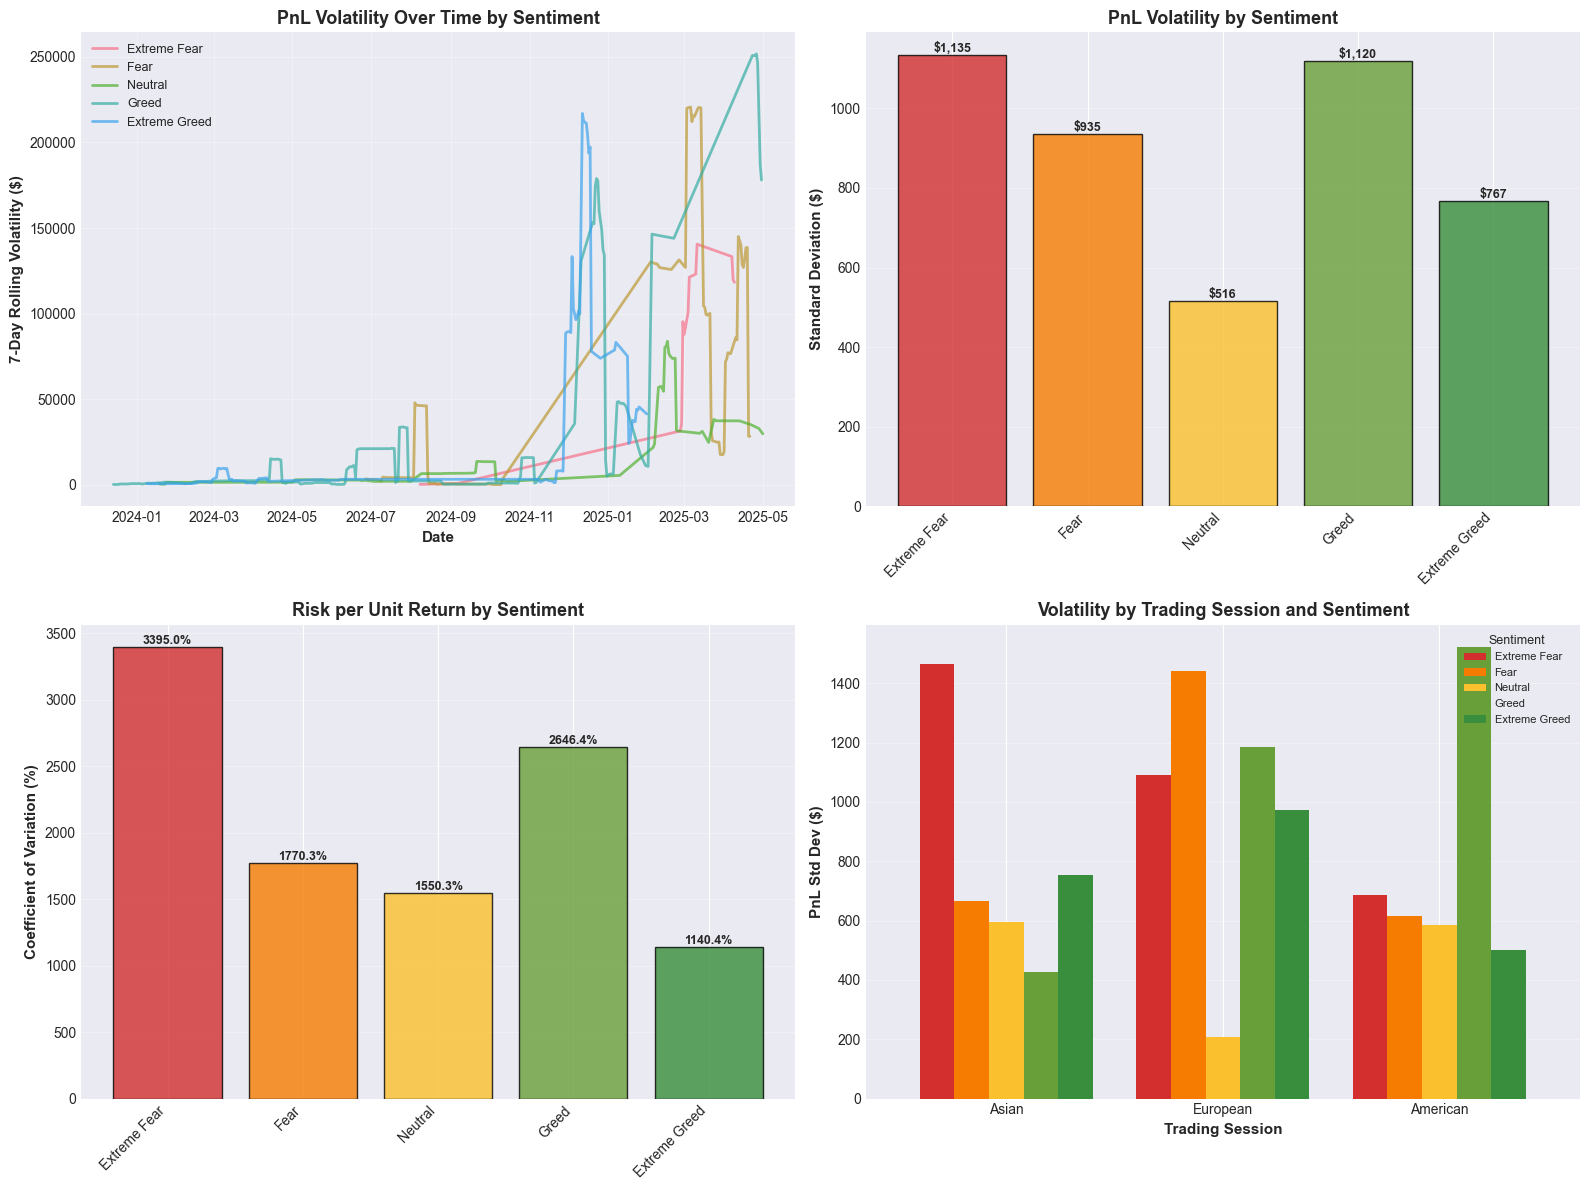


💡 Volatility Insights:
   Highest volatility: Extreme Fear ($1,134.68)
   Lowest volatility: Neutral ($515.68)
   Most efficient (lowest CV): Extreme Greed (1140.4%)


In [19]:
# Analyze volatility patterns by sentiment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rolling volatility by sentiment
ax1 = axes[0, 0]
for sentiment in sentiment_order:
    sentiment_data = merged_df[merged_df['sentiment_category'] == sentiment].sort_values('Date')
    if len(sentiment_data) > 0:
        # Calculate 7-day rolling standard deviation
        sentiment_daily = sentiment_data.groupby('Date')['Net_PnL'].sum().reset_index()
        sentiment_daily['Rolling_Vol'] = sentiment_daily['Net_PnL'].rolling(window=7, min_periods=1).std()
        ax1.plot(sentiment_daily['Date'], sentiment_daily['Rolling_Vol'], 
                label=sentiment, alpha=0.7, linewidth=2)

ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('7-Day Rolling Volatility ($)', fontsize=11, fontweight='bold')
ax1.set_title('PnL Volatility Over Time by Sentiment', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Volatility distribution
ax2 = axes[0, 1]
volatility_data = merged_df.groupby('sentiment_category')['Net_PnL'].std().reindex(sentiment_order)
bars = ax2.bar(range(len(volatility_data)), volatility_data.values, color=colors, 
               edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(sentiment_order)))
ax2.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax2.set_ylabel('Standard Deviation ($)', fontsize=11, fontweight='bold')
ax2.set_title('PnL Volatility by Sentiment', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Coefficient of Variation (Risk per unit return)
ax3 = axes[1, 0]
cv_data = merged_df.groupby('sentiment_category').agg({
    'Net_PnL': ['mean', 'std']
})
cv_data['CV'] = (cv_data[('Net_PnL', 'std')] / cv_data[('Net_PnL', 'mean')].abs()) * 100
cv_values = cv_data['CV'].reindex(sentiment_order)

bars3 = ax3.bar(range(len(cv_values)), cv_values.values, color=colors, 
                edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(sentiment_order)))
ax3.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax3.set_ylabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
ax3.set_title('Risk per Unit Return by Sentiment', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Intraday volatility by trading session
ax4 = axes[1, 1]
session_vol = merged_df.groupby(['Trading_Session', 'sentiment_category'])['Net_PnL'].std().unstack()
session_vol = session_vol.reindex(['Asian', 'European', 'American'])
session_vol[sentiment_order].plot(kind='bar', ax=ax4, color=colors, width=0.8)
ax4.set_xlabel('Trading Session', fontsize=11, fontweight='bold')
ax4.set_ylabel('PnL Std Dev ($)', fontsize=11, fontweight='bold')
ax4.set_title('Volatility by Trading Session and Sentiment', fontsize=13, fontweight='bold')
ax4.legend(title='Sentiment', fontsize=8, title_fontsize=9)
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n💡 Volatility Insights:")
print(f"   Highest volatility: {volatility_data.idxmax()} (${volatility_data.max():,.2f})")
print(f"   Lowest volatility: {volatility_data.idxmin()} (${volatility_data.min():,.2f})")
print(f"   Most efficient (lowest CV): {cv_values.idxmin()} ({cv_values.min():.1f}%)")

### 7.11 Drawdown Analysis - Maximum Loss Periods

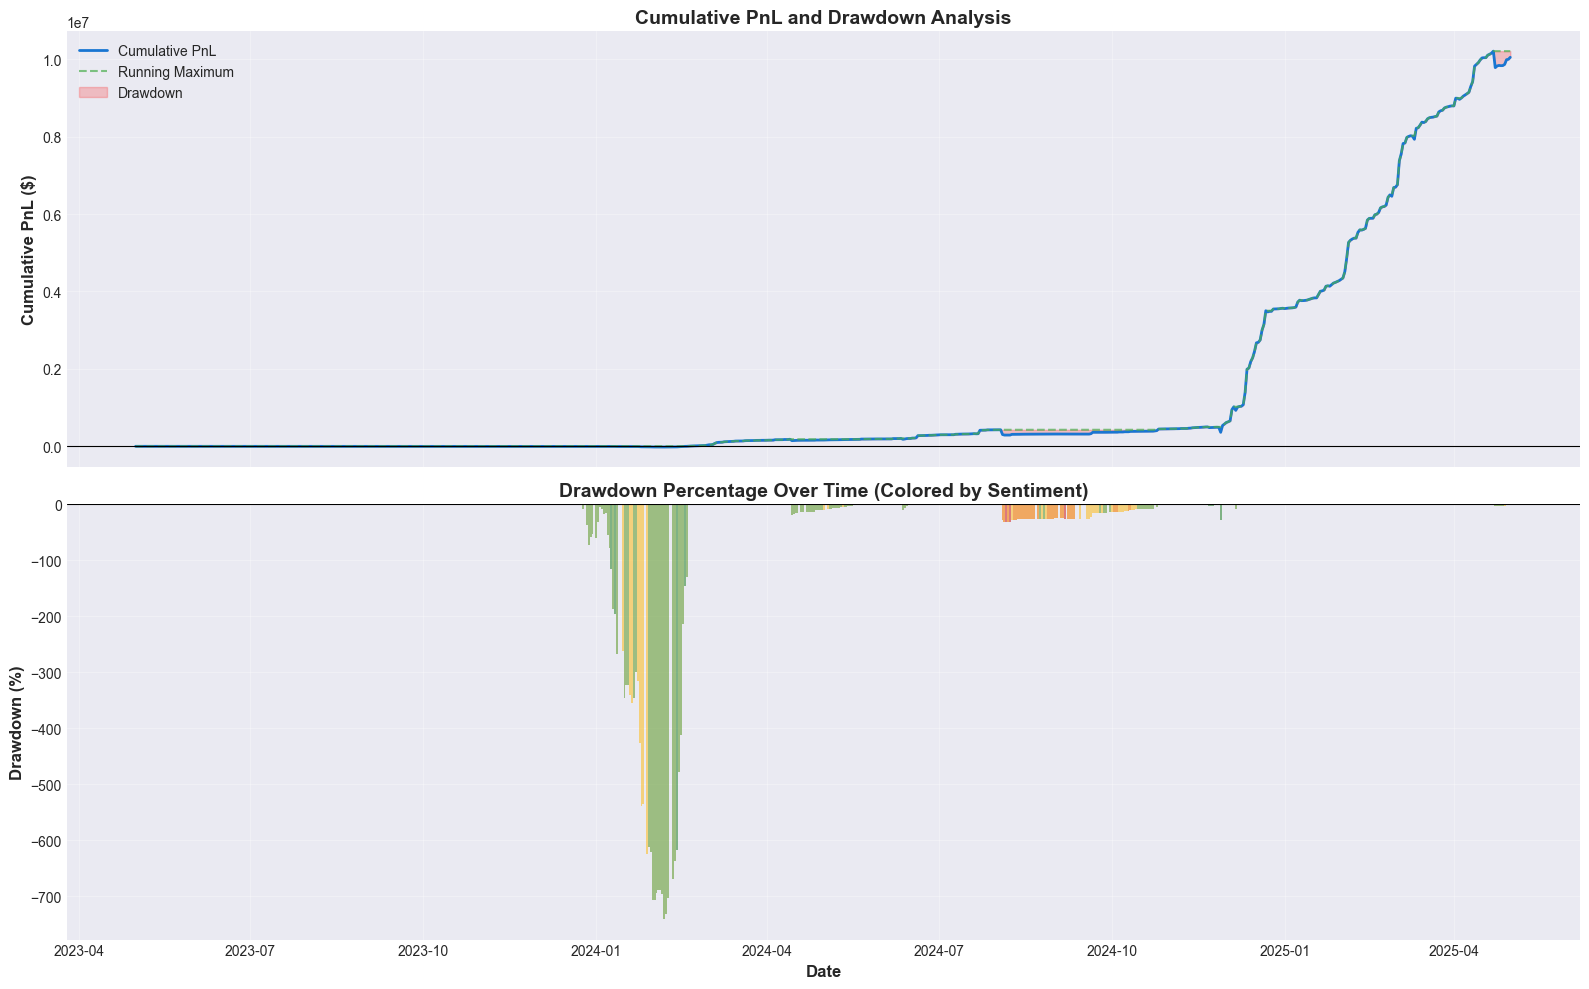

                         DRAWDOWN ANALYSIS SUMMARY

📉 Maximum Drawdown: $-426,362.31 (-740.73%)
   Date: 2025-04-23
   Market Sentiment: Greed
   Recovery: Not yet recovered

📊 Average Drawdown by Sentiment:
   Fear              : $-38,757.88
   Extreme Fear      : $-37,518.07
   Neutral           : $-33,107.16
   Greed             : $-22,220.75
   Extreme Greed     : $-2,360.77


In [20]:
# Calculate drawdown metrics
daily_pnl = merged_df.groupby('Date')['Net_PnL'].sum().sort_index()
cumulative_pnl = daily_pnl.cumsum()

# Calculate running maximum
running_max = cumulative_pnl.expanding().max()

# Calculate drawdown
drawdown = cumulative_pnl - running_max
drawdown_pct = (drawdown / running_max.replace(0, np.nan)) * 100

# Get sentiment for each day
daily_sentiment = merged_df.groupby('Date')['sentiment_category'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown')

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot 1: Cumulative PnL with drawdown zones
ax1.plot(cumulative_pnl.index, cumulative_pnl.values, color='#1976d2', 
         linewidth=2, label='Cumulative PnL')
ax1.plot(running_max.index, running_max.values, color='#4caf50', 
         linestyle='--', linewidth=1.5, alpha=0.7, label='Running Maximum')
ax1.fill_between(cumulative_pnl.index, cumulative_pnl.values, running_max.values, 
                  color='red', alpha=0.2, label='Drawdown')
ax1.set_ylabel('Cumulative PnL ($)', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative PnL and Drawdown Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Plot 2: Drawdown percentage
colors_map = {'Extreme Fear': '#d32f2f', 'Fear': '#f57c00', 'Neutral': '#fbc02d', 
              'Greed': '#689f38', 'Extreme Greed': '#388e3c'}
sentiment_colors = [colors_map.get(daily_sentiment.loc[date], '#999999') for date in drawdown_pct.index]

ax2.bar(drawdown_pct.index, drawdown_pct.values, color=sentiment_colors, alpha=0.6, width=1)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax2.set_title('Drawdown Percentage Over Time (Colored by Sentiment)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

# Calculate key metrics
max_drawdown = drawdown.min()
max_drawdown_pct = drawdown_pct.min()
max_drawdown_date = drawdown.idxmin()
max_drawdown_sentiment = daily_sentiment.loc[max_drawdown_date] if max_drawdown_date in daily_sentiment.index else 'Unknown'

# Recovery analysis
if max_drawdown < 0:
    recovery_dates = cumulative_pnl[cumulative_pnl.index > max_drawdown_date]
    peak_before_dd = running_max.loc[max_drawdown_date]
    recovery_date = recovery_dates[recovery_dates >= peak_before_dd].index[0] if len(recovery_dates[recovery_dates >= peak_before_dd]) > 0 else None
    if recovery_date:
        recovery_days = (recovery_date - max_drawdown_date).days
    else:
        recovery_days = None
else:
    recovery_days = None

print("="*80)
print(" "*25 + "DRAWDOWN ANALYSIS SUMMARY")
print("="*80)
print(f"\n📉 Maximum Drawdown: ${max_drawdown:,.2f} ({max_drawdown_pct:.2f}%)")
print(f"   Date: {max_drawdown_date.strftime('%Y-%m-%d')}")
print(f"   Market Sentiment: {max_drawdown_sentiment}")
if recovery_days:
    print(f"   Recovery Time: {recovery_days} days")
else:
    print(f"   Recovery: Not yet recovered")

# Drawdown by sentiment
print(f"\n📊 Average Drawdown by Sentiment:")
drawdown_by_sentiment = pd.DataFrame({
    'Date': drawdown.index,
    'Drawdown': drawdown.values,
    'Sentiment': daily_sentiment.values
})
avg_dd = drawdown_by_sentiment.groupby('Sentiment')['Drawdown'].mean().sort_values()
for sentiment, dd in avg_dd.items():
    print(f"   {sentiment:18s}: ${dd:,.2f}")

print("="*80)

### 7.8 Sentiment Distribution Over Time

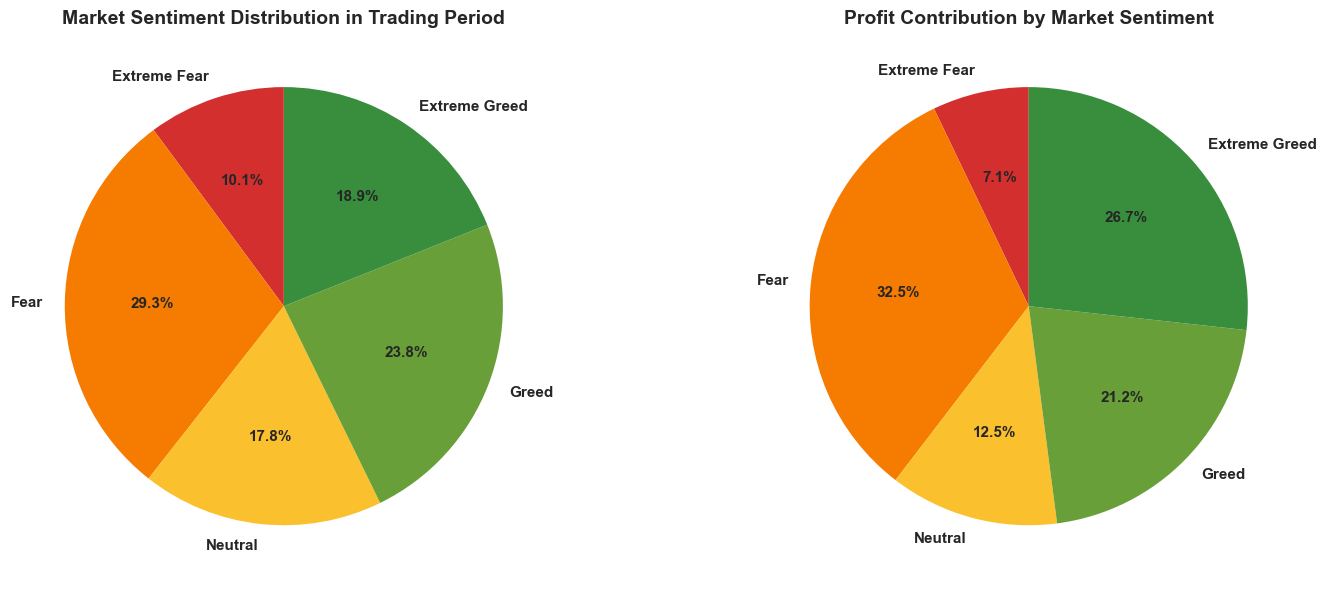

In [21]:
# Pie chart: Overall sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment distribution in dataset
sentiment_dist = merged_df['sentiment_category'].value_counts().reindex(sentiment_order)
ax1.pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Market Sentiment Distribution in Trading Period', fontsize=14, fontweight='bold')

# PnL contribution by sentiment
pnl_contribution = merged_df.groupby('sentiment_category')['Net_PnL'].sum().reindex(sentiment_order)
# Only show positive values for pie chart
pnl_positive = pnl_contribution.copy()
pnl_positive[pnl_positive < 0] = 0

if pnl_positive.sum() > 0:
    ax2.pie(pnl_positive.values, labels=pnl_positive.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Profit Contribution by Market Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Advanced Analysis: Behavioral Patterns

### 8.1 Trading Activity Patterns

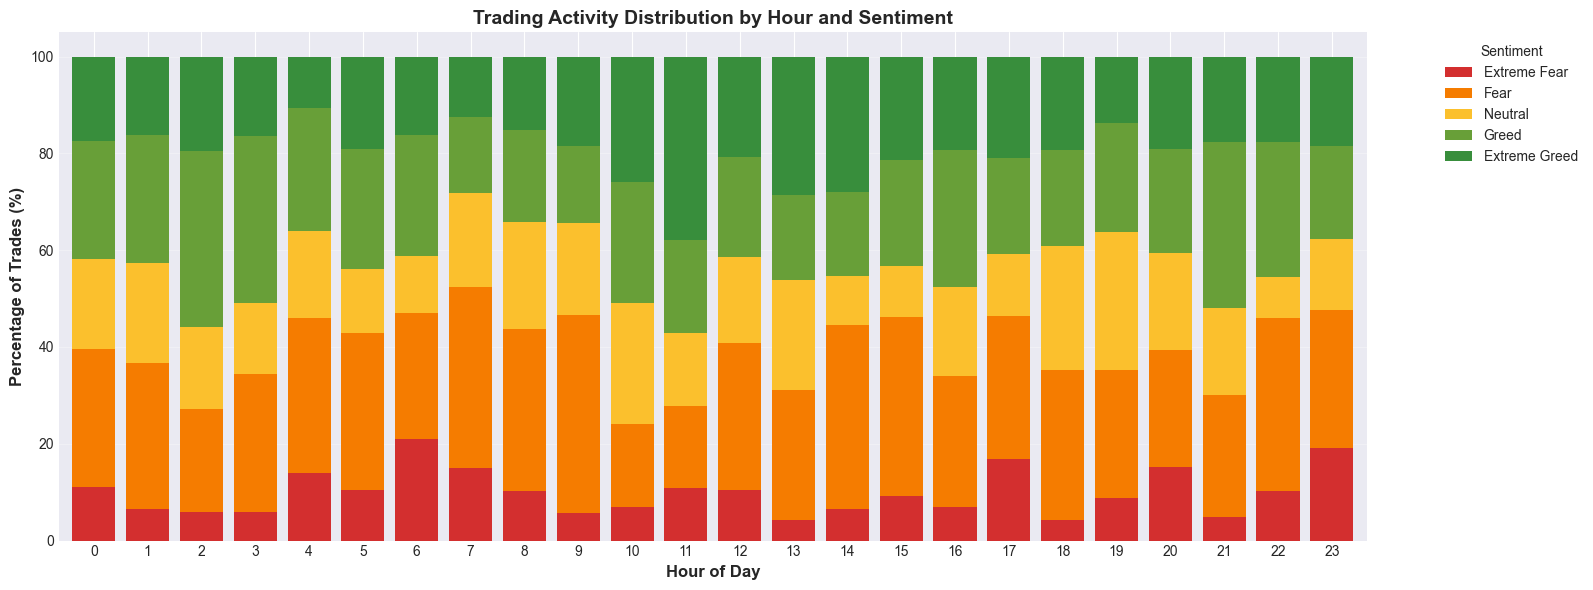

In [22]:
# Analyze trading patterns by hour and sentiment
hourly_sentiment = pd.crosstab(merged_df['Hour'], merged_df['sentiment_category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(16, 6))
hourly_sentiment[sentiment_order].plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.8)
ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Trades (%)', fontsize=12, fontweight='bold')
ax.set_title('Trading Activity Distribution by Hour and Sentiment', fontsize=14, fontweight='bold')
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 8.4 Leverage and Position Size Analysis by Sentiment

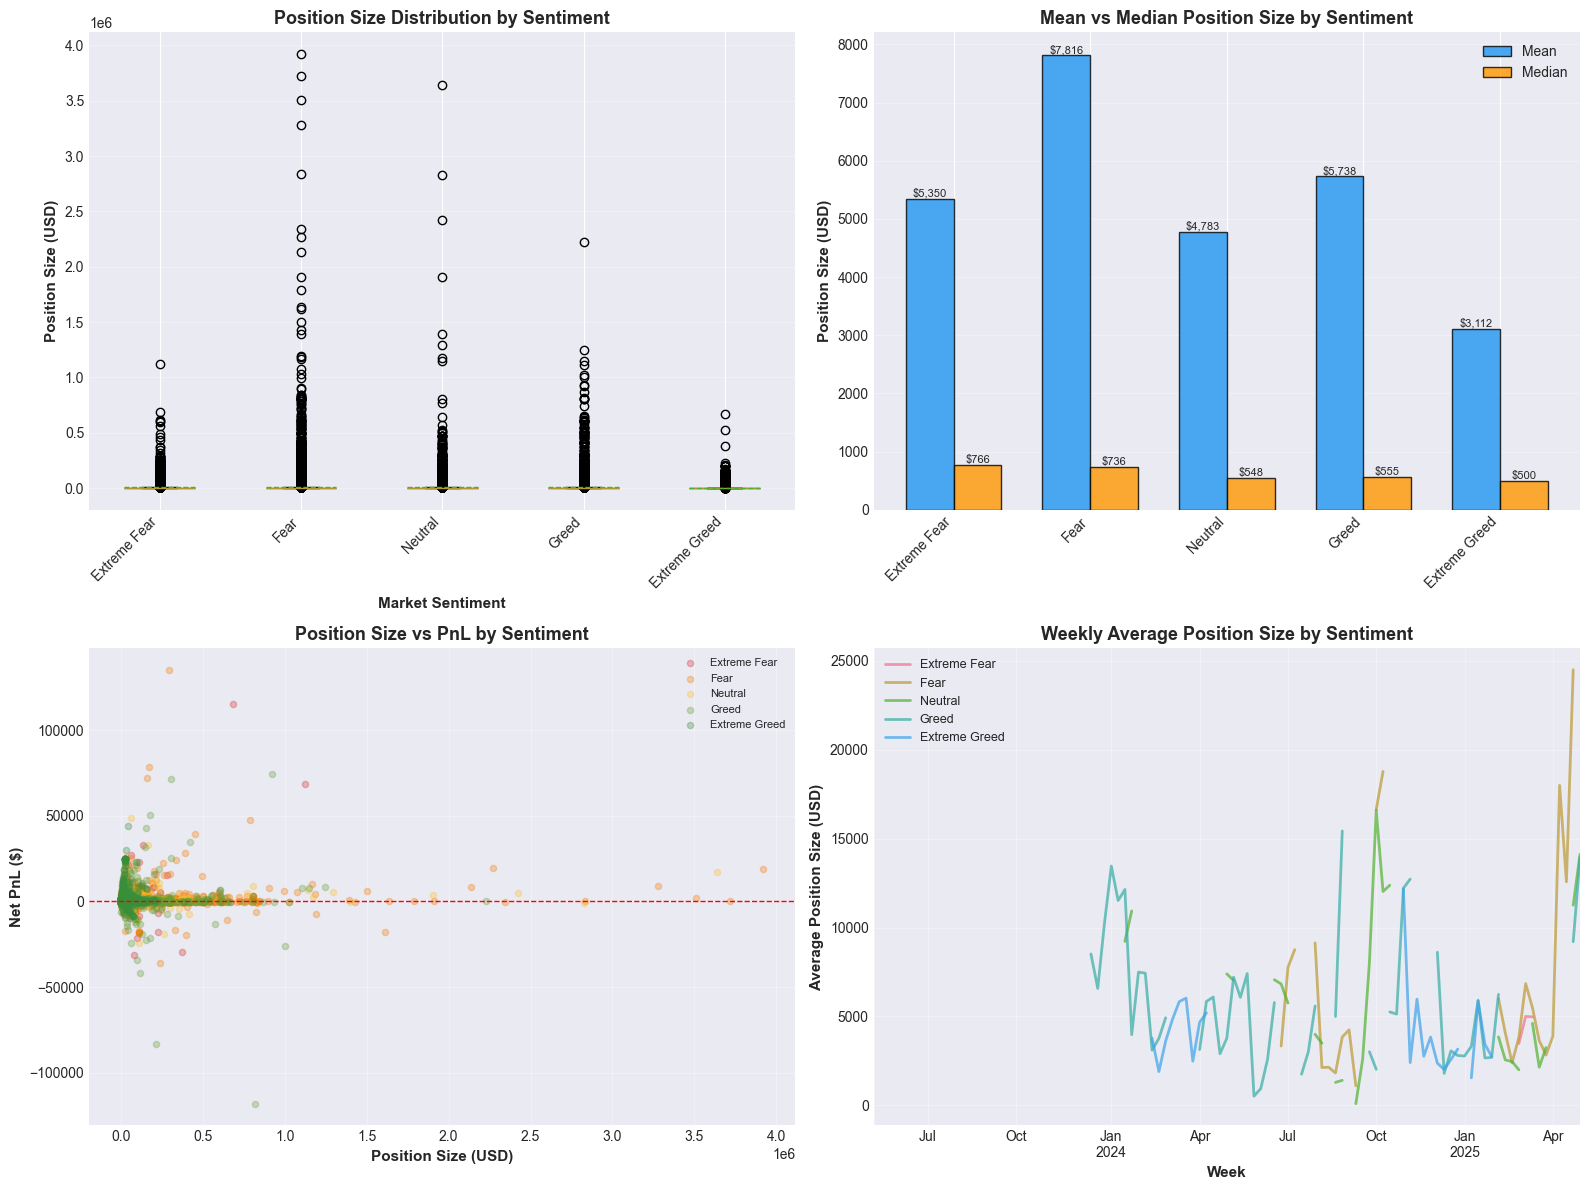

                    POSITION SIZING INSIGHTS

📊 Position Size Statistics by Sentiment:
--------------------------------------------------------------------------------

Extreme Fear:
  Mean: $5,349.73
  Median: $766.15
  Std Dev: $22,306.83
  Range: $0.01 - $1,120,971.60

Fear:
  Mean: $7,816.11
  Median: $735.96
  Std Dev: $51,914.86
  Range: $0.00 - $3,921,430.72

Neutral:
  Mean: $4,782.73
  Median: $547.65
  Std Dev: $37,461.88
  Range: $0.01 - $3,641,180.84

Greed:
  Mean: $5,737.96
  Median: $555.00
  Std Dev: $30,532.02
  Range: $0.00 - $2,227,114.71

Extreme Greed:
  Mean: $3,112.25
  Median: $500.05
  Std Dev: $11,062.00
  Range: $0.00 - $665,771.71



In [23]:
# Analyze position sizing behavior across different sentiment periods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Position size distribution by sentiment
ax1 = axes[0, 0]
position_size_data = []
labels_list = []
for sentiment in sentiment_order:
    data = merged_df[merged_df['sentiment_category'] == sentiment]['Size USD'].dropna()
    if len(data) > 0:
        position_size_data.append(data)
        labels_list.append(sentiment)

bp1 = ax1.boxplot(position_size_data, labels=labels_list, patch_artist=True, 
                   showmeans=True, meanline=True)
for patch, color in zip(bp1['boxes'], colors[:len(position_size_data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax1.set_xlabel('Market Sentiment', fontsize=11, fontweight='bold')
ax1.set_ylabel('Position Size (USD)', fontsize=11, fontweight='bold')
ax1.set_title('Position Size Distribution by Sentiment', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Average position size trend
ax2 = axes[0, 1]
avg_position = merged_df.groupby('sentiment_category')['Size USD'].agg(['mean', 'median']).reindex(sentiment_order)
x = np.arange(len(sentiment_order))
width = 0.35
bars1 = ax2.bar(x - width/2, avg_position['mean'].values, width, label='Mean', 
                color='#2196f3', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, avg_position['median'].values, width, label='Median', 
                color='#ff9800', alpha=0.8, edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax2.set_ylabel('Position Size (USD)', fontsize=11, fontweight='bold')
ax2.set_title('Mean vs Median Position Size by Sentiment', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}', ha='center', va='bottom', fontsize=8)

# 3. Risk behavior: Position size vs PnL correlation
ax3 = axes[1, 0]
for i, sentiment in enumerate(sentiment_order):
    sentiment_data = merged_df[merged_df['sentiment_category'] == sentiment]
    if len(sentiment_data) > 100:  # Only plot if sufficient data
        ax3.scatter(sentiment_data['Size USD'], sentiment_data['Net_PnL'], 
                   alpha=0.3, s=20, color=colors[i], label=sentiment)

ax3.set_xlabel('Position Size (USD)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Net PnL ($)', fontsize=11, fontweight='bold')
ax3.set_title('Position Size vs PnL by Sentiment', fontsize=13, fontweight='bold')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax3.legend(fontsize=8, loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. Position size variation over time
ax4 = axes[1, 1]
weekly_position = merged_df.groupby([merged_df['Date'].dt.to_period('W'), 'sentiment_category'])['Size USD'].mean().unstack()
for sentiment in sentiment_order:
    if sentiment in weekly_position.columns:
        weekly_position[sentiment].plot(ax=ax4, label=sentiment, linewidth=2, alpha=0.7)

ax4.set_xlabel('Week', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Position Size (USD)', fontsize=11, fontweight='bold')
ax4.set_title('Weekly Average Position Size by Sentiment', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9, loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display position sizing insights
print("="*80)
print(" "*20 + "POSITION SIZING INSIGHTS")
print("="*80)

position_stats = merged_df.groupby('sentiment_category')['Size USD'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).reindex(sentiment_order)

print("\n📊 Position Size Statistics by Sentiment:")
print("-" * 80)
for sentiment in sentiment_order:
    if sentiment in position_stats.index:
        stats = position_stats.loc[sentiment]
        print(f"\n{sentiment}:")
        print(f"  Mean: ${stats['mean']:,.2f}")
        print(f"  Median: ${stats['median']:,.2f}")
        print(f"  Std Dev: ${stats['std']:,.2f}")
        print(f"  Range: ${stats['min']:,.2f} - ${stats['max']:,.2f}")
        
print("\n" + "="*80)

### 8.5 Win Streak and Loss Streak Analysis

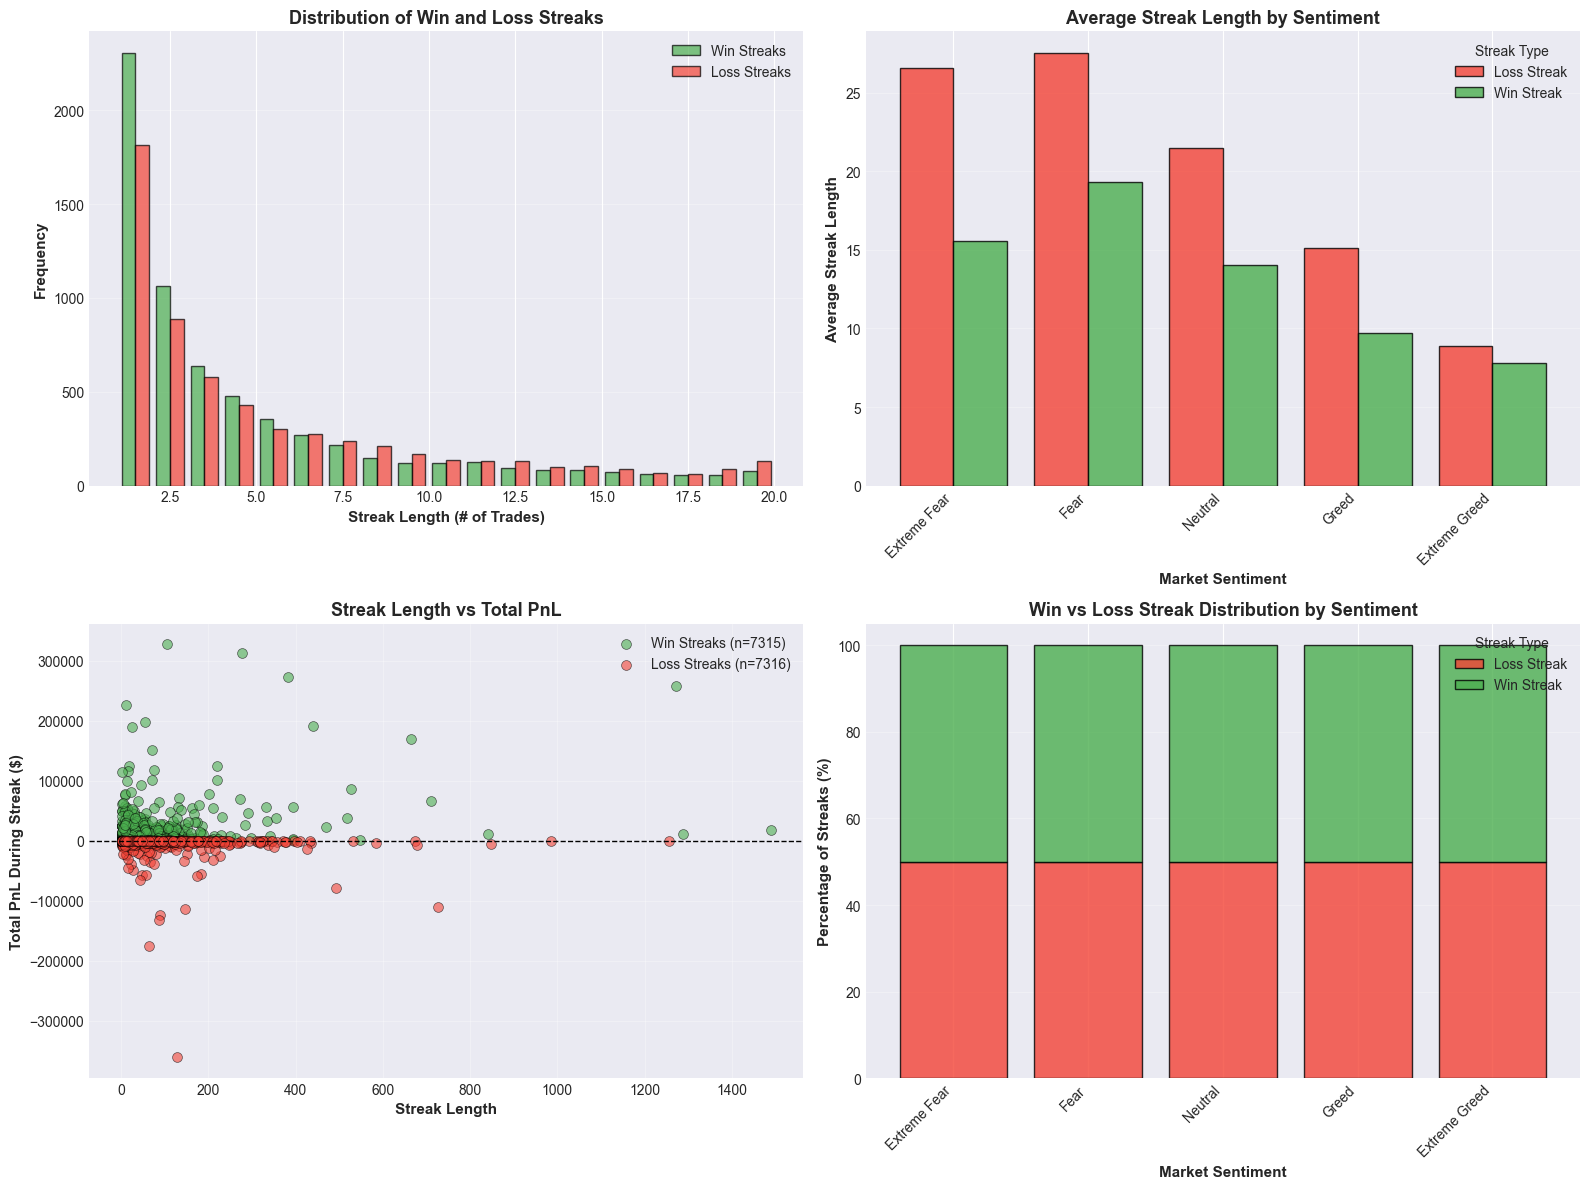

                         STREAK ANALYSIS INSIGHTS

📈 Win Streaks:
   Longest win streak: 1489 consecutive trades
   Average win streak length: 11.84 trades
   Total win streaks: 7315

📉 Loss Streaks:
   Longest loss streak: 1255 consecutive trades
   Average loss streak length: 17.03 trades
   Total loss streaks: 7316

💡 Sentiment Analysis:
   Extreme Fear      : 50.0% win streaks, 50.0% loss streaks
   Fear              : 50.0% win streaks, 50.0% loss streaks
   Neutral           : 50.1% win streaks, 49.9% loss streaks
   Greed             : 50.0% win streaks, 50.0% loss streaks
   Extreme Greed     : 50.0% win streaks, 50.0% loss streaks



In [24]:
# Analyze winning and losing streaks
sorted_df = merged_df.sort_values('Timestamp IST').reset_index(drop=True)

# Identify streaks
sorted_df['streak_id'] = (sorted_df['is_profitable'] != sorted_df['is_profitable'].shift()).cumsum()
streak_analysis = sorted_df.groupby('streak_id').agg({
    'is_profitable': 'first',
    'Net_PnL': ['sum', 'count'],
    'sentiment_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
})

streak_analysis.columns = ['is_win_streak', 'total_pnl', 'streak_length', 'dominant_sentiment']
streak_analysis['streak_type'] = streak_analysis['is_win_streak'].map({True: 'Win Streak', False: 'Loss Streak'})

# Find longest streaks
longest_win_streak = streak_analysis[streak_analysis['is_win_streak'] == True]['streak_length'].max()
longest_loss_streak = streak_analysis[streak_analysis['is_win_streak'] == False]['streak_length'].max()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Streak length distribution
ax1 = axes[0, 0]
win_streaks = streak_analysis[streak_analysis['is_win_streak'] == True]['streak_length']
loss_streaks = streak_analysis[streak_analysis['is_win_streak'] == False]['streak_length']

ax1.hist([win_streaks, loss_streaks], bins=range(1, 21), label=['Win Streaks', 'Loss Streaks'],
         color=['#4caf50', '#f44336'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Streak Length (# of Trades)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Win and Loss Streaks', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2. Average streak length by sentiment
ax2 = axes[0, 1]
streak_by_sentiment = streak_analysis.groupby(['dominant_sentiment', 'streak_type'])['streak_length'].mean().unstack(fill_value=0)
streak_by_sentiment = streak_by_sentiment.reindex(sentiment_order)
streak_by_sentiment.plot(kind='bar', ax=ax2, color=['#f44336', '#4caf50'], 
                         width=0.8, edgecolor='black', alpha=0.8)
ax2.set_xlabel('Market Sentiment', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Streak Length', fontsize=11, fontweight='bold')
ax2.set_title('Average Streak Length by Sentiment', fontsize=13, fontweight='bold')
ax2.legend(title='Streak Type', fontsize=10)
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Cumulative PnL during streaks
ax3 = axes[1, 0]
win_streak_pnl = streak_analysis[streak_analysis['is_win_streak'] == True]['total_pnl']
loss_streak_pnl = streak_analysis[streak_analysis['is_win_streak'] == False]['total_pnl']

ax3.scatter(win_streaks, win_streak_pnl, color='#4caf50', alpha=0.6, s=50, 
           label=f'Win Streaks (n={len(win_streaks)})', edgecolor='black', linewidth=0.5)
ax3.scatter(loss_streaks.values, loss_streak_pnl.values, color='#f44336', alpha=0.6, s=50, 
           label=f'Loss Streaks (n={len(loss_streaks)})', edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Streak Length', fontsize=11, fontweight='bold')
ax3.set_ylabel('Total PnL During Streak ($)', fontsize=11, fontweight='bold')
ax3.set_title('Streak Length vs Total PnL', fontsize=13, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Streak sentiment distribution
ax4 = axes[1, 1]
sentiment_streak_dist = pd.crosstab(streak_analysis['dominant_sentiment'], 
                                     streak_analysis['streak_type'], normalize='index') * 100
sentiment_streak_dist = sentiment_streak_dist.reindex(sentiment_order)
sentiment_streak_dist.plot(kind='bar', ax=ax4, stacked=True, 
                           color=['#f44336', '#4caf50'], width=0.8, edgecolor='black', alpha=0.8)
ax4.set_xlabel('Market Sentiment', fontsize=11, fontweight='bold')
ax4.set_ylabel('Percentage of Streaks (%)', fontsize=11, fontweight='bold')
ax4.set_title('Win vs Loss Streak Distribution by Sentiment', fontsize=13, fontweight='bold')
ax4.legend(title='Streak Type', fontsize=10)
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print streak insights
print("="*80)
print(" "*25 + "STREAK ANALYSIS INSIGHTS")
print("="*80)

print(f"\n📈 Win Streaks:")
print(f"   Longest win streak: {longest_win_streak} consecutive trades")
print(f"   Average win streak length: {win_streaks.mean():.2f} trades")
print(f"   Total win streaks: {len(win_streaks)}")

print(f"\n📉 Loss Streaks:")
print(f"   Longest loss streak: {longest_loss_streak} consecutive trades")
print(f"   Average loss streak length: {loss_streaks.mean():.2f} trades")
print(f"   Total loss streaks: {len(loss_streaks)}")

print(f"\n💡 Sentiment Analysis:")
for sentiment in sentiment_order:
    if sentiment in streak_analysis['dominant_sentiment'].values:
        sentiment_streaks = streak_analysis[streak_analysis['dominant_sentiment'] == sentiment]
        win_pct = (sentiment_streaks['is_win_streak'].sum() / len(sentiment_streaks)) * 100
        print(f"   {sentiment:18s}: {win_pct:.1f}% win streaks, {100-win_pct:.1f}% loss streaks")

print("\n" + "="*80)

### 8.2 Risk Analysis by Sentiment

In [25]:
# Calculate risk metrics by sentiment
risk_metrics = merged_df.groupby('sentiment_category').agg({
    'Net_PnL': ['mean', 'std', 'min', 'max'],
    'Size USD': ['mean', 'std']
}).round(2)

risk_metrics.columns = ['Avg_PnL', 'PnL_StdDev', 'Max_Loss', 'Max_Profit', 'Avg_Trade_Size', 'Trade_Size_StdDev']

# Calculate Sharpe-like ratio (mean/std)
risk_metrics['Risk_Reward_Ratio'] = (risk_metrics['Avg_PnL'] / risk_metrics['PnL_StdDev']).round(3)
risk_metrics = risk_metrics.reindex(sentiment_order)

print("Risk Metrics by Market Sentiment:")
print("="*120)
display(risk_metrics)

Risk Metrics by Market Sentiment:


,Avg_PnL,PnL_StdDev,Max_Loss,Max_Profit,Avg_Trade_Size,Trade_Size_StdDev,Risk_Reward_Ratio
sentiment_category,,,,,,,
Extreme Fear,33.42,"1,134.68","-31,044.72","115,218.48","5,349.73","22,306.83",0.03
Fear,52.80,934.64,"-35,705.50","135,299.80","7,816.11","51,914.86",0.06
Neutral,33.26,515.68,"-24,510.75","48,483.03","4,782.73","37,461.88",0.06
Greed,42.33,"1,120.18","-118,071.56","74,438.36","5,737.96","30,532.02",0.04
Extreme Greed,67.22,766.53,"-10,268.23","44,207.97","3,112.25","11,062.00",0.09


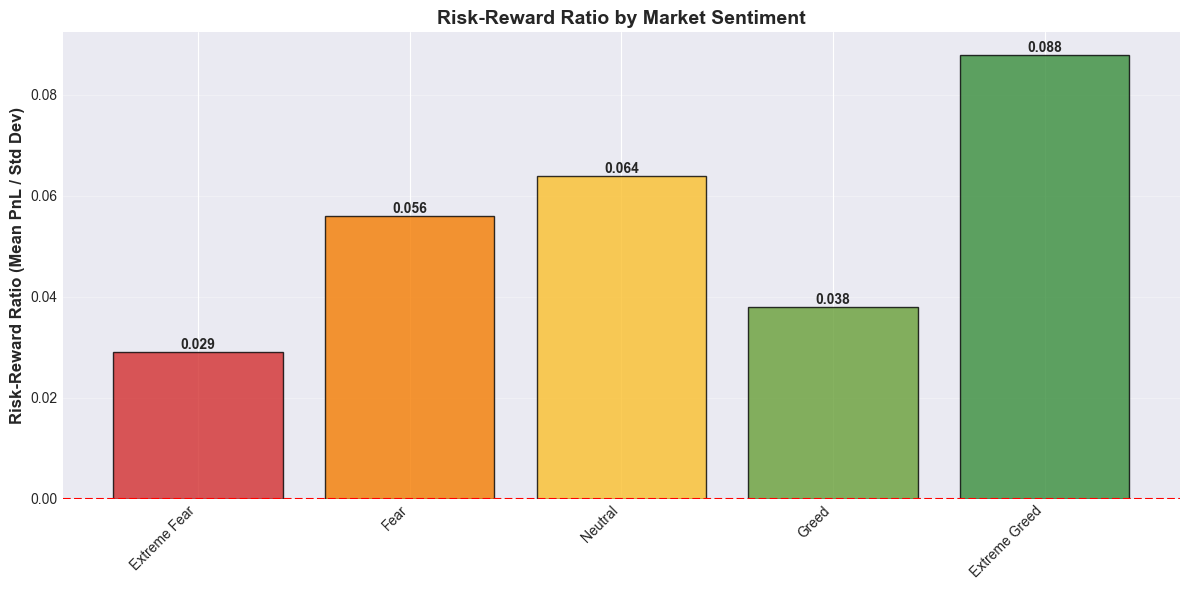

In [26]:
# Visualize risk-reward ratio
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(range(len(risk_metrics)), risk_metrics['Risk_Reward_Ratio'].values, 
              color=colors, edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(sentiment_order)))
ax.set_xticklabels(sentiment_order, rotation=45, ha='right')
ax.set_ylabel('Risk-Reward Ratio (Mean PnL / Std Dev)', fontsize=12, fontweight='bold')
ax.set_title('Risk-Reward Ratio by Market Sentiment', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

### 8.3 Profitable vs Unprofitable Trades Analysis

In [27]:
# Compare profitable vs unprofitable trades
profitable_analysis = merged_df.groupby(['sentiment_category', 'is_profitable']).agg({
    'Net_PnL': ['mean', 'count'],
    'Size USD': 'mean'
}).round(2)

profitable_analysis.columns = ['Avg_PnL', 'Trade_Count', 'Avg_Trade_Size']
profitable_analysis = profitable_analysis.reset_index()
profitable_analysis['is_profitable'] = profitable_analysis['is_profitable'].map({True: 'Profitable', False: 'Unprofitable'})

print("Profitable vs Unprofitable Trades by Sentiment:")
print("="*100)
display(profitable_analysis)

Profitable vs Unprofitable Trades by Sentiment:


,sentiment_category,is_profitable,Avg_PnL,Trade_Count,Avg_Trade_Size
0,Extreme Fear,Unprofitable,-48.12,13515,"5,089.32"
1,Extreme Fear,Profitable,173.18,7885,"5,796.08"
2,Extreme Greed,Unprofitable,-13.45,21288,"3,406.99"
3,Extreme Greed,Profitable,159.03,18704,"2,776.79"
4,Fear,Unprofitable,-17.78,36390,"7,724.03"
5,Fear,Profitable,153.72,25447,"7,947.78"
6,Greed,Unprofitable,-35.88,30622,"5,746.79"
7,Greed,Profitable,163.97,19687,"5,724.24"
8,Neutral,Unprofitable,-18.00,22766,"4,027.07"
9,Neutral,Profitable,111.48,14920,"5,935.78"


## 9. Key Insights and Summary

In [29]:
# Enhanced comprehensive insights with advanced metrics
print("="*100)
print(" "*35 + "KEY INSIGHTS & FINDINGS")
print("="*100)

# 1. Best performing sentiment
best_sentiment = sentiment_performance['Total_PnL'].idxmax()
best_pnl = sentiment_performance.loc[best_sentiment, 'Total_PnL']
print(f"\n1. 🏆 BEST PERFORMING SENTIMENT: {best_sentiment}")
print(f"   ├─ Total PnL: ${best_pnl:,.2f}")
print(f"   ├─ Average PnL per trade: ${sentiment_performance.loc[best_sentiment, 'Avg_PnL']:.2f}")
print(f"   ├─ Win Rate: {sentiment_performance.loc[best_sentiment, 'Win_Rate']:.2f}%")
print(f"   ├─ Total Trades: {int(sentiment_performance.loc[best_sentiment, 'Trade_Count']):,}")
print(f"   └─ Risk-Reward Ratio: {risk_metrics.loc[best_sentiment, 'Risk_Reward_Ratio']:.3f}")

# 2. Worst performing sentiment
worst_sentiment = sentiment_performance['Total_PnL'].idxmin()
worst_pnl = sentiment_performance.loc[worst_sentiment, 'Total_PnL']
print(f"\n2. ⚠️  WORST PERFORMING SENTIMENT: {worst_sentiment}")
print(f"   ├─ Total PnL: ${worst_pnl:,.2f}")
print(f"   ├─ Average PnL per trade: ${sentiment_performance.loc[worst_sentiment, 'Avg_PnL']:.2f}")
print(f"   ├─ Win Rate: {sentiment_performance.loc[worst_sentiment, 'Win_Rate']:.2f}%")
print(f"   ├─ Total Trades: {int(sentiment_performance.loc[worst_sentiment, 'Trade_Count']):,}")
print(f"   └─ Risk-Reward Ratio: {risk_metrics.loc[worst_sentiment, 'Risk_Reward_Ratio']:.3f}")

# 3. Trading volume insights
print(f"\n3. 📊 TRADING VOLUME PATTERNS:")
total_volume_all = sentiment_performance['Total_Volume'].sum()
for sentiment in sentiment_order:
    if sentiment in sentiment_performance.index:
        count = sentiment_performance.loc[sentiment, 'Trade_Count']
        volume = sentiment_performance.loc[sentiment, 'Total_Volume']
        pct = (count / total_trades) * 100
        vol_pct = (volume / total_volume_all) * 100
        print(f"   ├─ {sentiment:18s}: {int(count):6,} trades ({pct:5.1f}%) | Volume: ${volume:12,.0f} ({vol_pct:5.1f}%)")

# 4. Risk-reward insights
best_risk_reward = risk_metrics['Risk_Reward_Ratio'].idxmax()
worst_risk_reward = risk_metrics['Risk_Reward_Ratio'].idxmin()
print(f"\n4. ⚖️  RISK-REWARD ANALYSIS:")
print(f"   ├─ Best Risk-Reward: {best_risk_reward} (Ratio: {risk_metrics.loc[best_risk_reward, 'Risk_Reward_Ratio']:.3f})")
print(f"   ├─ Worst Risk-Reward: {worst_risk_reward} (Ratio: {risk_metrics.loc[worst_risk_reward, 'Risk_Reward_Ratio']:.3f})")
print(f"   └─ Interpretation: Higher ratio = more consistent returns relative to volatility")

# 5. Correlation insights
sentiment_pnl_corr = numeric_features['Sentiment Value'].corr(numeric_features['Net PnL'])
print(f"\n5. 🔗 CORRELATION ANALYSIS:")
print(f"   ├─ Sentiment Value ↔ Net PnL: {sentiment_pnl_corr:.4f}")
if abs(sentiment_pnl_corr) < 0.1:
    corr_interpretation = "Very weak correlation - sentiment has minimal direct impact"
elif abs(sentiment_pnl_corr) < 0.3:
    corr_interpretation = "Weak correlation - sentiment shows limited direct influence"
elif abs(sentiment_pnl_corr) < 0.5:
    corr_interpretation = "Moderate correlation - sentiment has noticeable impact"
else:
    corr_interpretation = "Strong correlation - sentiment significantly affects performance"
print(f"   └─ {corr_interpretation}")

# 6. Buy vs Sell patterns
print(f"\n6. 📈 BUY vs SELL BEHAVIOR:")
overall_buy_pct = (merged_df['Side'] == 'BUY').sum() / len(merged_df) * 100
print(f"   ├─ Overall: {overall_buy_pct:.1f}% BUY, {100-overall_buy_pct:.1f}% SELL")
for sentiment in sentiment_order:
    if sentiment in merged_df['sentiment_category'].values:
        sentiment_trades = merged_df[merged_df['sentiment_category'] == sentiment]
        buy_pct = (sentiment_trades['Side'] == 'BUY').sum() / len(sentiment_trades) * 100
        buy_pnl = sentiment_trades[sentiment_trades['Side'] == 'BUY']['Net_PnL'].sum()
        sell_pnl = sentiment_trades[sentiment_trades['Side'] == 'SELL']['Net_PnL'].sum()
        print(f"   ├─ {sentiment:18s}: {buy_pct:5.1f}% BUY (PnL: ${buy_pnl:10,.0f}) | {100-buy_pct:5.1f}% SELL (PnL: ${sell_pnl:10,.0f})")

# 7. Fee Impact Analysis
print(f"\n7. 💰 FEE IMPACT ANALYSIS:")
fee_to_pnl_ratio = (total_fees / abs(total_pnl)) * 100 if total_pnl != 0 else 0
gross_pnl = total_pnl + total_fees
print(f"   ├─ Total Fees Paid: ${total_fees:,.2f}")
print(f"   ├─ Gross PnL (before fees): ${gross_pnl:,.2f}")
print(f"   ├─ Net PnL (after fees): ${total_pnl:,.2f}")
print(f"   ├─ Fee-to-PnL Ratio: {fee_to_pnl_ratio:.2f}%")
print(f"   └─ Average Fee per Trade: ${(total_fees / total_trades):.2f}")

# 8. Volatility insights
print(f"\n8. 📉 VOLATILITY & DRAWDOWN:")
volatility_by_sentiment = merged_df.groupby('sentiment_category')['Net_PnL'].std()
most_volatile = volatility_by_sentiment.idxmax()
least_volatile = volatility_by_sentiment.idxmin()
print(f"   ├─ Most Volatile: {most_volatile} (σ = ${volatility_by_sentiment[most_volatile]:,.2f})")
print(f"   ├─ Least Volatile: {least_volatile} (σ = ${volatility_by_sentiment[least_volatile]:,.2f})")
print(f"   └─ Overall Portfolio Volatility: ${merged_df['Net_PnL'].std():,.2f}")

# 9. Time-based patterns
print(f"\n9. ⏰ TIME-BASED PATTERNS:")
session_performance = merged_df.groupby('Trading_Session')['Net_PnL'].agg(['sum', 'mean', 'count'])
best_session = session_performance['sum'].idxmax()
print(f"   ├─ Best Trading Session: {best_session}")
print(f"   │  └─ Total PnL: ${session_performance.loc[best_session, 'sum']:,.2f} ({int(session_performance.loc[best_session, 'count'])} trades)")
for session in ['Asian', 'European', 'American']:
    if session in session_performance.index:
        print(f"   ├─ {session:10s} Session: ${session_performance.loc[session, 'sum']:10,.2f} | Avg: ${session_performance.loc[session, 'mean']:7,.2f} | Trades: {int(session_performance.loc[session, 'count']):,}")

# 10. Profitability Distribution
print(f"\n10. 📊 PROFITABILITY DISTRIBUTION:")
profit_trades = merged_df[merged_df['is_profitable']]
loss_trades = merged_df[~merged_df['is_profitable']]
print(f"    ├─ Profitable Trades: {len(profit_trades):,} ({win_rate:.2f}%)")
print(f"    │  ├─ Total Profit: ${profit_trades['Net_PnL'].sum():,.2f}")
print(f"    │  └─ Average Profit: ${profit_trades['Net_PnL'].mean():,.2f}")
print(f"    ├─ Unprofitable Trades: {len(loss_trades):,} ({100-win_rate:.2f}%)")
print(f"    │  ├─ Total Loss: ${loss_trades['Net_PnL'].sum():,.2f}")
print(f"    │  └─ Average Loss: ${loss_trades['Net_PnL'].mean():,.2f}")
print(f"    └─ Profit Factor: {abs(profit_trades['Net_PnL'].sum() / loss_trades['Net_PnL'].sum()):.2f}x")

print("\n" + "="*100)
print(" "*30 + "STRATEGIC RECOMMENDATIONS")
print("="*100)

print(f"\n? RECOMMENDATION 1: Sentiment-Based Strategy")
if best_pnl > 0:
    print(f"   ✓ INCREASE trading activity during '{best_sentiment}' periods")
    print(f"     - This sentiment showed highest profitability (${best_pnl:,.2f})")
    print(f"     - Win rate: {sentiment_performance.loc[best_sentiment, 'Win_Rate']:.2f}%")
    print(f"     - Consider allocating larger position sizes in this environment")
else:
    print(f"   ⚠ All sentiments showed losses - comprehensive strategy review needed")
    print(f"     - Evaluate market conditions and trading approach")

if worst_pnl < 0:
    print(f"\n? RECOMMENDATION 2: Risk Management")
    print(f"   ✓ REDUCE exposure during '{worst_sentiment}' periods")
    print(f"     - Negative PnL: ${worst_pnl:,.2f}")
    print(f"     - Win rate only {sentiment_performance.loc[worst_sentiment, 'Win_Rate']:.2f}%")
    print(f"     - Implement tighter stop-losses or skip trading in this condition")

print(f"\n? RECOMMENDATION 3: Risk-Reward Optimization")
print(f"   ✓ Prioritize '{best_risk_reward}' periods for consistency")
print(f"     - Best risk-adjusted performance (Ratio: {risk_metrics.loc[best_risk_reward, 'Risk_Reward_Ratio']:.3f})")
print(f"     - Lower volatility relative to returns")
print(f"   ⚠ Avoid '{worst_risk_reward}' conditions")
print(f"     - High volatility with poor risk-adjusted returns")

if overall_buy_pct > 60:
    print(f"\n? RECOMMENDATION 4: Directional Balance")
    print(f"   ⚠ Portfolio heavily skewed toward BUY trades ({overall_buy_pct:.1f}%)")
    print(f"     - Consider more balanced long/short approach")
    print(f"     - Explore short-selling opportunities during bearish sentiments")
elif overall_buy_pct < 40:
    print(f"\n? RECOMMENDATION 4: Directional Balance")
    print(f"   ⚠ Portfolio heavily skewed toward SELL trades ({100-overall_buy_pct:.1f}%)")
    print(f"     - Consider long positions during bullish sentiments")
    print(f"     - Balance short bias with long opportunities")
else:
    print(f"\n💡 RECOMMENDATION 4: Directional Balance")
    print(f"   ✓ Portfolio shows balanced approach ({overall_buy_pct:.1f}% BUY, {100-overall_buy_pct:.1f}% SELL)")
    print(f"     - Maintain this balanced strategy")

print(f"\n? RECOMMENDATION 5: Fee Optimization")
if fee_to_pnl_ratio > 10:
    print(f"   ⚠ HIGH FEE IMPACT: Fees represent {fee_to_pnl_ratio:.2f}% of gross PnL")
    print(f"     - Reduce trade frequency to lower fee burden")
    print(f"     - Use maker orders instead of taker orders when possible")
    print(f"     - Consider batch trading to minimize transaction costs")
elif fee_to_pnl_ratio > 5:
    print(f"   ✓ MODERATE FEE IMPACT: Fees at {fee_to_pnl_ratio:.2f}% of gross PnL")
    print(f"     - Acceptable level, but room for optimization")
else:
    print(f"   ✓ LOW FEE IMPACT: Fees only {fee_to_pnl_ratio:.2f}% of gross PnL")
    print(f"     - Efficient trading approach maintained")

print(f"\n💡 RECOMMENDATION 6: Session-Based Trading")
print(f"   ✓ Focus on {best_session} session for best results")
session_pnl = session_performance['sum']
for session in session_pnl.sort_values(ascending=False).index:
    status = "✓" if session_pnl[session] > 0 else "⚠"
    print(f"     {status} {session:10s}: ${session_pnl[session]:,.2f}")

print("\n" + "="*100)
print(" "*35 + "ACTION ITEMS SUMMARY")
print("="*100)

print(f"\n🎯 Immediate Actions:")
print(f"   1. Increase position sizes during {best_sentiment} periods (+{abs(best_pnl/worst_pnl if worst_pnl != 0 else 1):.1f}x better performance)")
print(f"   2. Reduce or avoid trading during {worst_sentiment} periods")
print(f"   3. Focus trading on {best_session} session for optimal performance")
if fee_to_pnl_ratio > 10:
    print(f"   4. Implement fee reduction strategy - currently losing {fee_to_pnl_ratio:.1f}% to fees")
print(f"   5. Maintain risk-reward ratio above {risk_metrics['Risk_Reward_Ratio'].median():.3f}")

print("\n" + "="*100)
print(" "*40 + "END OF ANALYSIS")
print("="*100)

The history saving thread hit an unexpected error (UnicodeEncodeError('utf-8', '# Enhanced comprehensive insights with advanced metrics\nprint("="*100)\nprint(" "*35 + "KEY INSIGHTS & FINDINGS")\nprint("="*100)\n\n# 1. Best performing sentiment\nbest_sentiment = sentiment_performance[\'Total_PnL\'].idxmax()\nbest_pnl = sentiment_performance.loc[best_sentiment, \'Total_PnL\']\nprint(f"\\n1. 🏆 BEST PERFORMING SENTIMENT: {best_sentiment}")\nprint(f"   ├─ Total PnL: ${best_pnl:,.2f}")\nprint(f"   ├─ Average PnL per trade: ${sentiment_performance.loc[best_sentiment, \'Avg_PnL\']:.2f}")\nprint(f"   ├─ Win Rate: {sentiment_performance.loc[best_sentiment, \'Win_Rate\']:.2f}%")\nprint(f"   ├─ Total Trades: {int(sentiment_performance.loc[best_sentiment, \'Trade_Count\']):,}")\nprint(f"   └─ Risk-Reward Ratio: {risk_metrics.loc[best_sentiment, \'Risk_Reward_Ratio\']:.3f}")\n\n# 2. Worst performing sentiment\nworst_sentiment = sentiment_performance[\'Total_PnL\'].idxmin()\nworst_pnl = sentiment_pe

UnicodeEncodeError: 'utf-8' codec can't encode character '\udca1' in position 10: surrogates not allowed

### 9.1 Performance Metrics Dashboard

In [ ]:
# Create a comprehensive performance metrics dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall Performance Gauge
ax1 = fig.add_subplot(gs[0, 0])
categories = ['Total PnL', 'Win Rate', 'Avg Trade', 'Risk-Reward', 'Fee Efficiency']
normalized_scores = [
    min(total_pnl / 10000000, 1),  # Normalize to max 10M
    win_rate / 100,
    min(avg_pnl_per_trade / 100, 1),  # Normalize to max $100
    min(risk_metrics['Risk_Reward_Ratio'].mean() / 0.1, 1),  # Normalize to 0.1
    1 - min(fee_to_pnl_ratio / 20, 1)  # Inverse, normalize to 20%
]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
normalized_scores += normalized_scores[:1]
angles += angles[:1]

ax1 = plt.subplot(gs[0, 0], projection='polar')
ax1.plot(angles, normalized_scores, 'o-', linewidth=2, color='#1976d2')
ax1.fill(angles, normalized_scores, alpha=0.25, color='#1976d2')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories, size=9)
ax1.set_ylim(0, 1)
ax1.set_title('Overall Performance Score', fontsize=12, fontweight='bold', pad=20)
ax1.grid(True)

# 2. PnL Trend with Moving Average
ax2 = fig.add_subplot(gs[0, 1:])
daily_pnl_series = merged_df.groupby('Date')['Net_PnL'].sum().sort_index()
cumulative = daily_pnl_series.cumsum()
ma_7 = daily_pnl_series.rolling(window=7).mean()
ma_30 = daily_pnl_series.rolling(window=30).mean()

ax2.plot(daily_pnl_series.index, cumulative, color='#1976d2', linewidth=2, label='Cumulative PnL')
ax2.plot(daily_pnl_series.index, ma_7.cumsum(), color='#ff9800', linewidth=1.5, 
         alpha=0.7, linestyle='--', label='7-Day MA (Cumulative)')
ax2.plot(daily_pnl_series.index, ma_30.cumsum(), color='#4caf50', linewidth=1.5, 
         alpha=0.7, linestyle='--', label='30-Day MA (Cumulative)')
ax2.fill_between(daily_pnl_series.index, 0, cumulative, where=(cumulative >= 0), 
                 alpha=0.2, color='green', interpolate=True)
ax2.fill_between(daily_pnl_series.index, 0, cumulative, where=(cumulative < 0), 
                 alpha=0.2, color='red', interpolate=True)
ax2.set_xlabel('Date', fontsize=10, fontweight='bold')
ax2.set_ylabel('Cumulative PnL ($)', fontsize=10, fontweight='bold')
ax2.set_title('Cumulative PnL with Moving Averages', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# 3. Win Rate Comparison
ax3 = fig.add_subplot(gs[1, 0])
win_rates = sentiment_performance['Win_Rate'].reindex(sentiment_order)
colors_wr = ['#d32f2f' if wr < 40 else '#ff9800' if wr < 45 else '#4caf50' for wr in win_rates]
bars = ax3.barh(range(len(win_rates)), win_rates.values, color=colors_wr, edgecolor='black', alpha=0.8)
ax3.set_yticks(range(len(sentiment_order)))
ax3.set_yticklabels(sentiment_order, fontsize=9)
ax3.set_xlabel('Win Rate (%)', fontsize=10, fontweight='bold')
ax3.set_title('Win Rate by Sentiment', fontsize=12, fontweight='bold')
ax3.axvline(x=50, color='red', linestyle='--', linewidth=1.5, label='50% Benchmark')
ax3.grid(axis='x', alpha=0.3)
ax3.legend(fontsize=8)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width + 1, bar.get_y() + bar.get_height()/2., f'{width:.1f}%',
             ha='left', va='center', fontweight='bold', fontsize=8)

# 4. Risk-Reward Matrix
ax4 = fig.add_subplot(gs[1, 1])
avg_returns = sentiment_performance['Avg_PnL'].reindex(sentiment_order)
volatilities = risk_metrics['PnL_StdDev'].reindex(sentiment_order)
for i, sentiment in enumerate(sentiment_order):
    ax4.scatter(volatilities[i], avg_returns[i], s=300, color=colors[i], 
               alpha=0.7, edgecolor='black', linewidth=2)
    ax4.annotate(sentiment, (volatilities[i], avg_returns[i]), 
                fontsize=8, ha='center', va='center', fontweight='bold')
ax4.set_xlabel('Volatility (Std Dev)', fontsize=10, fontweight='bold')
ax4.set_ylabel('Average Return ($)', fontsize=10, fontweight='bold')
ax4.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.axvline(x=volatilities.median(), color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4.grid(True, alpha=0.3)

# 5. Profit Distribution
ax5 = fig.add_subplot(gs[1, 2])
profit_dist = merged_df[merged_df['Net_PnL'].between(
    merged_df['Net_PnL'].quantile(0.05), 
    merged_df['Net_PnL'].quantile(0.95)
)]['Net_PnL']
ax5.hist(profit_dist, bins=50, color='#1976d2', alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax5.axvline(x=profit_dist.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: ${profit_dist.mean():.2f}')
ax5.set_xlabel('Net PnL ($)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax5.set_title('PnL Distribution (5th-95th Percentile)', fontsize=12, fontweight='bold')
ax5.legend(fontsize=8)
ax5.grid(axis='y', alpha=0.3)

# 6. Monthly Performance Heatmap
ax6 = fig.add_subplot(gs[2, :2])
merged_df['YearMonth'] = merged_df['Date'].dt.to_period('M')
monthly_perf = merged_df.groupby(['YearMonth', 'sentiment_category'])['Net_PnL'].sum().unstack(fill_value=0)
if len(monthly_perf) > 0:
    sns.heatmap(monthly_perf.T, annot=True, fmt='.0f', cmap='RdYlGn', center=0, 
               cbar_kws={'label': 'Net PnL ($)'}, ax=ax6, linewidths=0.5)
    ax6.set_xlabel('Month', fontsize=10, fontweight='bold')
    ax6.set_ylabel('Sentiment', fontsize=10, fontweight='bold')
    ax6.set_title('Monthly PnL Heatmap by Sentiment', fontsize=12, fontweight='bold')
    plt.setp(ax6.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax6.get_yticklabels(), rotation=0, fontsize=8)

# 7. Top Performance Metrics Table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
metrics_data = [
    ['Metric', 'Value'],
    ['─' * 20, '─' * 15],
    ['Total Trades', f'{total_trades:,}'],
    ['Net PnL', f'${total_pnl:,.2f}'],
    ['Win Rate', f'{win_rate:.2f}%'],
    ['Avg PnL/Trade', f'${avg_pnl_per_trade:.2f}'],
    ['Best Sentiment', best_sentiment],
    ['Worst Sentiment', worst_sentiment],
    ['Total Fees', f'${total_fees:,.2f}'],
    ['Fee Impact', f'{fee_to_pnl_ratio:.2f}%'],
]
table = ax7.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(metrics_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#1976d2')
        table[(i, 1)].set_facecolor('#1976d2')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    elif i == 1:
        table[(i, 0)].set_facecolor('#f0f0f0')
        table[(i, 1)].set_facecolor('#f0f0f0')
    else:
        table[(i, 0)].set_facecolor('#ffffff')
        table[(i, 1)].set_facecolor('#ffffff')
ax7.set_title('Key Performance Metrics', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('📊 COMPREHENSIVE TRADING PERFORMANCE DASHBOARD', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n✓ Performance Dashboard Generated Successfully!")

## 10. Export Results

In [ ]:
# Save key results to CSV files
sentiment_performance.to_csv('sentiment_performance_summary.csv')
risk_metrics.to_csv('risk_metrics_by_sentiment.csv')
daily_performance.to_csv('daily_performance_with_sentiment.csv', index=False)

print("✓ Results exported to CSV files:")
print("  - sentiment_performance_summary.csv")
print("  - risk_metrics_by_sentiment.csv")
print("  - daily_performance_with_sentiment.csv")

✓ Results exported to CSV files:
  - sentiment_performance_summary.csv
  - risk_metrics_by_sentiment.csv
  - daily_performance_with_sentiment.csv


## Conclusion

This analysis has provided comprehensive insights into how Bitcoin market sentiment affects trader performance on Hyperliquid. Key findings include:

- **Sentiment Impact**: Different market sentiments show varying levels of profitability
- **Behavioral Patterns**: Trading volume and position sizing varies with market sentiment
- **Risk Characteristics**: Each sentiment period has distinct risk-reward profiles
- **Strategic Opportunities**: Specific recommendations for optimizing trading during different market conditions

The visualizations and metrics presented can guide more informed trading decisions and risk management strategies.